In [1]:
import time
from pathlib import Path
import textwrap

import numpy as np
import torch
import transformers
from transformers import (AutoConfig, AutoModelForCausalLM, AutoTokenizer,
                          BitsAndBytesConfig)


import os
os.chdir("/home/feline/master-generation")

#from modules.GPTQ_loader import load_quantized
from modules.text_generation import generate_reply
import modules.shared as shared
from modules.model import load_model

import hashlib
import spacy
# Load the English language model
nlp = spacy.load("en_core_web_sm")

#shared.model_name = "dolphin-2.6-mistral-7b-Mistral-7B-Instruct-v0.1"
#shared.model_name = "dolphin-2.9.4-llama3.1-8b"
shared.model_name = "Meta-Llama-3.1-8B"
#shared.model_name = "_LLama2-7b-gptq-4bit-32g-actorder_True"
#shared.model_name = "_Mistral-7b-gptq-4bit-32g-actorder_True"
#shared.model_name = "llama3-dolpin-8b-4bit-128g-actorder_True"
#shared.model_name = "llama3-8b-instruct-gptq-4bit-128g-actorder_False"
#shared.model_name = "Llama-3-8B-Instruct-GPTQ-4-Bit"
shared.act_order = True
#shared.model_name = "llama-3-8b-chatml"
#shared.model_name = "llama3-8b-awq-dolphin"

print(f"Loading {shared.model_name}...")
t0 = time.time()
#shared.model = load_quantized(shared.model_name)
#shared.tokenizer = AutoTokenizer.from_pretrained(Path(f"models/{shared.model_name}/"))
#shared.tokenizer.truncation_side = 'left'

shared.groupsize = 128
shared.wbits = 4

shared.use_flash_attention_2 = True
shared.model, shared.tokenizer = load_model(shared.model_name, gptq = False, awq=False)

print(f"Loaded the model in {(time.time()-t0):.2f} seconds.")


import pandas as pd
df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)  #the header is in the first row

shared.sensorimotor = df.set_index('Word').T.to_dict('dict')
shared.classes = ['Auditory.mean', 'Gustatory.mean','Haptic.mean','Interoceptive.mean','Olfactory.mean','Visual.mean','Foot_leg.mean','Hand_arm.mean','Head.mean','Mouth.mean','Torso.mean']


from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli",device=-1)

def secure_hash_to_numbers_icml_version(input_string, range_list):

    
    nlp = spacy.load("en_core_web_sm")

    if (input_string is None):
        return [5,5]
    doc = nlp(input_string)

    core = [token.lemma_ for token in doc if not token.is_stop]

    core_str = " ".join(core)

    input_string = core_str
    
    hashed_bytes = hashlib.sha256(core_str.encode()).digest()

    num_numbers = len(range_list)
    hashed_integers = [int.from_bytes(hashed_bytes[i:i+4], byteorder='big') for i in range(0, num_numbers * 4, 4)]

    #cast hash to integer, then use modulo to map to required range
    result_numbers = []
    for i in range(num_numbers):
        range_min, range_max = range_list[i]
        integer = hashed_integers[i]
        mapped_number = (integer % (range_max - range_min + 1)) + range_min
        result_numbers.append(mapped_number)
    
    print(result_numbers)
    
    
    '''
    import subprocess
    def run_classifier(param):
        # Replace 'your_conda_env' with the name of your Conda environment
        run_classifier_script = f"mamba run -n classifier python classifier.py '{param}'"
        command = f"/bin/bash -c '{run_classifier_script}'"

        # Run the command and capture output
        completed_process = subprocess.run(command, shell=True, text=True, capture_output=True)
        return completed_process.stdout.strip()

    # Rest of your LLM code
    # ...
    # Call the function where needed and pass the parameter
    classifier_output = run_classifier("This is a test.")
    print("Output from classifier:", classifier_output)
    '''
    '''
    
    labels = [
        "Statement",      # Declarative statements or assertions
        "Question",       # Any form of inquiry or query
        "Request",        # Sentences that ask for something
        "Command",        # Imperative or directive statements
        "Offer",          # Proposals or suggestions
        "Explanation",    # Providing clarifications or reasons
        "Description",    # Descriptive details about something
        "Opinion",        # Personal views or judgments
        "Fact",           # Factual or objective information
        "Assumption",     # Sentences based on assumptions
        "Belief",         # Expressions of belief or conviction
        "Doubt",          # Expressions of uncertainty or skepticism
        "Hope",           # Sentences expressing hope or aspiration
        "Wish",           # Expressions of desires or wishes
        "Fear",           # Statements expressing fear or concern
        "Joy",            # Expressions of happiness or joy
        "Sadness",        # Expressions of sorrow or sadness
        "Anger",          # Statements expressing anger or frustration
        "Surprise",       # Expressions of surprise or astonishment
        "Sarcasm",        # Sarcastic or ironic statements
        "Joke",           # Humorous or joking statements
        "Quote",          # Quotations or cited speech
        "Agreement",      # Expressions of agreement or affirmation
        "Disagreement",   # Expressions of disagreement or dissent
        "Gratitude",      # Expressions of thanks or appreciation
        "Apology"         # Statements of apology or regret
    ]
    labels = ['Scientific Concepts',
        'Technical Explanations',
        'Historical Context',
        'Cultural Insights',
        'Environmental Issues',
        'Health and Medicine',
        'Technological Developments',
        'Economic Theories',
        'Political Analysis',
        'Philosophical Concepts',
        'Educational Methods',
        'Psychological Theories',
        'Artistic Movements',
        'Literary Analysis',
        'Global Events',
        'Culinary Traditions',
        'Mathematical Concepts',
        'Physical Principles',
        'Astronomical Discoveries',
        'Geographical Information',
        'Social Dynamics',
        'Legal Interpretations',
        'Business Strategies',
        'Sports and Fitness',
        'Linguistic Features',
        'Techniques in Science and Technology']

    labels2 = [
        "Health",
        "Technology",
        "Politics",
        "Economy",
        "Education",
        "Environment",
        "Sports",
        "Travel",
        "Food",
        "Music",
        "Business"
    ]
    labels2 = ['Science and Technology',
        'Health and Environmental Issues',
        'Arts, Culture, and History',
        'Economic and Political Analysis',
        'Philosophy and Psychology',
        'Education and Learning Methods',
        'Global and Social Dynamics',
        'Legal and Ethical Discussions',
        'Business and Management',
        'Sports, Fitness, and Recreation',
        'Language and Literature']

    if not input_string:
        print("NO STRING DUMMY WAS THROWN!!!!!!!!!")
        input_string = "dummy."

    #results = classifier(input_string, labels)
    #predicted_label = results['labels'][0]
    #label_index = labels.index(predicted_label)

    #results2 = classifier(input_string, labels2)
    #predicted_label2 = results2['labels'][0]
    #label_index2 = labels2.index(predicted_label2)
   
    
    return [label_index2, label_index]
    '''
    
    return result_numbers
def secure_hash_for_sentence(last_sentence, range_min, range_max):
    doc = nlp(last_sentence)
    core_sentence = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    core_sentence_str = " ".join(core_sentence)
    print(core_sentence_str)
    
    hashed_sentence_bytes = hashlib.sha256(core_sentence_str.encode()).digest()
    hashed_sentence_integers = int.from_bytes(hashed_sentence_bytes[:4], byteorder='big')
    
    mapped_sentence_number = (hashed_sentence_integers % (range_max - range_min + 1)) + range_min
    return mapped_sentence_number


def secure_hash_for_token(last_token, range_min, range_max):
    hashed_token_bytes = hashlib.sha256(str(last_token.item()).encode()).digest()
    hashed_token_integers = int.from_bytes(hashed_token_bytes[:4], byteorder='big')
    
    mapped_token_number = (hashed_token_integers % (range_max - range_min + 1)) + range_min
    return mapped_token_number

def secure_hash_to_numbers(last_sentence, last_token, range_list):
    
    result_numbers = []
    
    # Compute the secure hash for the last token if last_token is not None
    if last_token is not None:
        token_hash = secure_hash_for_token(last_token, range_list[0][0], range_list[0][1])
    else:
        token_hash = shared.secret_key[0]  # Reuse the shared key if last_token is missing
    
    result_numbers.append(token_hash)
    
    # Compute the secure hash for the last sentence if last_sentence is not None
    if last_sentence is not None:
        sentence_hash = secure_hash_for_sentence(last_sentence, range_list[1][0], range_list[1][1])
    else:
        sentence_hash = shared.secret_key[1]  # Reuse the shared key if last_sentence is missing
    
    result_numbers.append(sentence_hash)
    
    return result_numbers

def get_last_sentence(text):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    if sentences:
        return sentences[-1]
    else:
        return None  # Return None if there are no sentences


Loading Meta-Llama-3.1-8B...
Loading Meta-Llama-3.1-8B...


The model was loaded with use_flash_attention_2=True, which is deprecated and may be removed in a future release. Please use `attn_implementation="flash_attention_2"` instead.
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded the model in 8.51 seconds.

Loaded the model in 8.51 seconds.


/home/feline/miniconda3/envs/textgen/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
#question = "### Human: Explain in detail: What is the Nordschleife? ### Assistant:"

#question = "A chat between a human and an assistant. ### HUMAN: What is Formula One? ### ASSISTANT:"

#question = "What is Formula One?"
progress = 0
prompts = [
    "What is the concept of artificial intelligence?",
    "How does photosynthesis work in plants?",
    "Who is the author of the famous play 'Romeo and Juliet'?",
    "Explain the theory of relativity proposed by Albert Einstein.",
    "What are the main features of a black hole?",
    "Describe the process of DNA replication in cells.",
    "Who painted the Mona Lisa and why is it famous?",
    "What is the significance of the Industrial Revolution in history?",
    "Explain the principles of supply and demand in economics.",
    "Who is known as the 'Father of Modern Physics'?",
    "What are the major causes of climate change?",
    "Describe the structure and function of the human nervous system.",
    "Who wrote the classic novel 'Pride and Prejudice'?",
    "What are the key components of a computer's central processing unit (CPU)?",
    "Explain the process of evolution by natural selection.",
    "Who is credited with the invention of the World Wide Web?",
    "Describe the major events of the American Civil War.",
    "What is the role of mitochondria in a cell?",
    "Who is the current president of France?",
    "What are the main features of a Shakespearean sonnet?",
    "Explain the concept of quantum entanglement in physics.",
    "Who discovered penicillin and how did it revolutionize medicine?",
    "Describe the structure of the Earth's atmosphere.",
    "What is the significance of the Magna Carta in legal history?",
    "Who is the author of 'The Great Gatsby'?",
    "Explain the principles of the theory of plate tectonics.",
    "What are the different forms of renewable energy sources?",
    "Who won the Nobel Prize in Physics in the year 2020?",
    "Describe the process of cellular respiration in living organisms.",
    "Who is considered the 'Father of Modern Chemistry'?"
]


prompts = [
    "What is the capital of France?",
    "Explain the process of photosynthesis.",
    "What are the basic rules of chess?",
    "Describe the water cycle.",
    "Summarize the plot of 'Romeo and Juliet'.",
    "What is Newton's first law of motion?",
    "How do you make a simple omelette?",
    "List the seven continents.",
    "What are the primary colors?",
    "Explain the concept of supply and demand in economics.",
    "What is the function of the heart in the human body?",
    "How does a compass work?",
    "Define the term 'ecosystem'.",
    "What is the boiling point of water?",
    "Describe how a computer works.",
    "What are the planets in our solar system?",
    "Explain the basics of HTML.",
    "Who was Albert Einstein?",
    "What is the Pythagorean theorem?",
    "How do you calculate the area of a circle?",
    "What is photosynthesis?",
    "Describe the life cycle of a butterfly.",
    "What is the Declaration of Independence?",
    "How do you change a flat tire?",
    "What is the process of evaporation?",
    "Explain the rules of soccer.",
    "What is the significance of the Great Wall of China?",
    "How do solar panels generate electricity?",
    "What causes earthquakes?",
    "Describe the structure of DNA.",
    "What is a black hole?",
    "How do airplanes fly?",
    "Explain the concept of gravity.",
    "What is global warming?",
    "Describe the human digestive system.",
    "What is the Renaissance?",
    "How does the stock market work?",
    "What are renewable energy sources?",
    "Explain the basic principles of democracy.",
    "What is virtual reality?",
    "How do vaccines work?",
    "What is the internet?",
    "Describe the process of making chocolate.",
    "What is a haiku?",
    "How do bees make honey?",
    "What is the theory of relativity?",
    "Explain the function of the lungs.",
    "What is a balanced diet?",
    "Describe the phases of the moon.",
    "What is artificial intelligence?",
    "How does a refrigerator work?",
    "Explain the concept of time zones.",
    "What is the significance of the Mona Lisa?",
    "How is glass made?",
    "What are the causes of World War II?",
    "Explain the importance of biodiversity.",
    "What is the structure of an atom?",
    "How does a camera work?",
    "What is mindfulness?",
    "Describe the process of recycling."
]

prompts = [
    "What causes the seasons to change?",
    "Describe the French Revolution.",
    "What is quantum mechanics?",
    "How do you solve a quadratic equation?",
    "What is the significance of the Berlin Wall?",
    "Explain the process of fermentation.",
    "What is the human genome project?",
    "How does the internet work?",
    "What are the symptoms of diabetes?",
    "Describe the process of cell division.",
    "What is the theory of evolution?",
    "How do you make bread?",
    "What are the major religions of the world?",
    "Explain the concept of inflation in economics.",
    "What is the significance of the Magna Carta?",
    "How does a microwave oven work?",
    "What is the structure of the United Nations?",
    "Describe the American Civil War.",
    "What causes tsunamis?",
    "How do you write a business plan?",
    "What is the importance of the Rosetta Stone?",
    "Explain the principles of non-violent resistance.",
    "What is a supernova?",
    "How do you calculate compound interest?",
    "Describe the process of photosynthesis in detail.",
    "What is the impact of climate change on oceans?",
    "Explain the concept of blockchain.",
    "What is the importance of the Silk Road?",
    "How do antibiotics work?",
    "Describe the Greek pantheon of gods.",
    "What is dark matter?",
    "How do you make a website?",
    "Explain the process of nuclear fusion.",
    "What is the history of the internet?",
    "Describe the principles of classical architecture.",
    "What causes volcanic eruptions?",
    "How do you create a budget?",
    "What is the importance of the Suez Canal?",
    "Explain the concept of artificial selection.",
    "What is the difference between mitosis and meiosis?",
    "Describe the Crusades.",
    "What is the formula for calculating velocity?",
    "How does a sewing machine work?",
    "What is the significance of the Dead Sea Scrolls?",
    "Explain the basics of cryptocurrency.",
    "What is the function of the kidneys in the human body?",
    "Describe the battle of Gettysburg.",
    "What causes global economic crises?",
    "How do you make a pizza?",
    "What is the theory behind black holes?",
    "Describe the structure and function of the brain.",
    "What is the significance of Machu Picchu?",
    "How does a light bulb work?",
    "Explain the concept of the Big Bang Theory.",
    "What is the role of the World Health Organization?",
    "Describe the process of making wine.",
    "What is the importance of quantum computing?",
    "How do you improve your memory?",
    "What is the story behind the Trojan War?",
    "Describe the function of the immune system.",
    "What causes lightning and thunder?",
    "How do you calculate BMI (Body Mass Index)?",
    "What is the significance of Stonehenge?",
    "Explain the concept of virtual private networks (VPNs).",
    "What is the difference between renewable and non-renewable energy?",
    "Describe the process of making beer.",
    "What is the significance of the Panama Canal?",
    "How does a GPS system work?",
    "What is the history of the Olympic Games?",
    "Explain the concept of machine learning.",
    "What is the importance of the Gutenberg Bible?",
    "How do you make a campfire?",
    "What causes addiction?",
    "Describe the process of making cheese.",
    "What is the significance of the Hagia Sophia?",
    "How does Bluetooth technology work?",
    "What is the history of cryptography?",
    "Explain the concept of sustainable development.",
    "What is the importance of the International Space Station?",
    "How do you make chocolate chip cookies?",
    "What causes allergies?",
    "Describe the process of making soap.",
    "What is the significance of the Colosseum in Rome?",
    "How does nuclear power work?",
    "What is the history of the English language?",
    "Explain the concept of the electoral college in the United States.",
    "What is the importance of the Human Rights Declaration?",
    "How do you make a smoothie?",
    "What causes migraines?",
    "Describe the process of making tea.",
    "What is the significance of the Taj Mahal?",
    "How does solar energy work?",
    "What is the history of the Roman Empire?",
    "Explain the concept of photosynthesis in algae.",
    "What is the importance of the Great Barrier Reef?",
    "How do you make a latte?",
    "What causes insomnia?",
    "Describe the process of making sushi.",
    "What is the significance of the Great Pyramid of Giza?",
    "How does wind energy work?",
    "What is the history of the Vikings?",
    "Explain the concept of genetic engineering.",
    "What is the importance of the Mona Lisa in the art world?",
]
prompts = [
    "What is the capital of France?",
    "Explain the process of photosynthesis.",
    "What are the basic rules of chess?",
    "Describe the water cycle.",
    "Summarize the plot of 'Romeo and Juliet'.",
    "What is Newton's first law of motion?",
    "How do you make a simple omelette?",
    "List the seven continents.",
    "What are the primary colors?",
    "Explain the concept of supply and demand in economics.",
    "What is the function of the heart in the human body?",
    "How does a compass work?",
    "Define the term 'ecosystem'.",
    "What is the boiling point of water?",
    "Describe how a computer works.",
    "What are the planets in our solar system?",
    "Explain the basics of HTML.",
    "Who was Albert Einstein?",
    "What is the Pythagorean theorem?",
    "How do you calculate the area of a circle?",
    "What is photosynthesis?",
    "Describe the life cycle of a butterfly.",
    "What is the Declaration of Independence?",
    "How do you change a flat tire?",
    "What is the process of evaporation?",
    "Explain the rules of soccer.",
    "What is the significance of the Great Wall of China?",
    "How do solar panels generate electricity?",
    "What causes earthquakes?",
    "Describe the structure of DNA.",
    "What is a black hole?",
    "How do airplanes fly?",
    "Explain the concept of gravity.",
    "What is global warming?",
    "Describe the human digestive system.",
    "What is the Renaissance?",
    "How does the stock market work?",
    "What are renewable energy sources?",
    "Explain the basic principles of democracy.",
    "What is virtual reality?",
    "How do vaccines work?",
    "What is the internet?",
    "Describe the process of making chocolate.",
    "What is a haiku?",
    "How do bees make honey?",
    "What is the theory of relativity?",
    "Explain the function of the lungs.",
    "What is a balanced diet?",
    "Describe the phases of the moon.",
    "What is artificial intelligence?",
    "How does a refrigerator work?",
    "Explain the concept of time zones.",
    "What is the significance of the Mona Lisa?",
    "How is glass made?",
    "What are the causes of World War II?",
    "Explain the importance of biodiversity.",
    "What is the structure of an atom?",
    "How does a camera work?",
    "What is mindfulness?",
    "Describe the process of recycling.",
    "How do you make homemade ice cream?",
    "What causes the aurora borealis (Northern Lights)?",
    "Describe the process of making pasta.",
    "What is the significance of the Sphinx in Egypt?",
    "How does a battery work?",
    "What is the history of the Mayan civilization?",
    "Explain the concept of the Internet of Things (IoT).",
    "What is the importance of the Rosetta Stone in understanding ancient languages?",
    "How do you make a quilt?",
    "What causes the greenhouse effect?",
    "Describe the process of making jam.",
    "What is the significance of the Acropolis in Athens?",
    "How does an electric car work?",
    "What is the history of the French language?",
    "Explain the concept of cloud computing.",
    "What is the importance of the discovery of penicillin?",
    "How do you make a salad?",
    "What causes ocean currents?",
    "Describe the process of distillation.",
    "What is the significance of the Leaning Tower of Pisa?",
    "How does a satellite work?",
    "What is the history of the Chinese language?",
    "Explain the concept of digital marketing.",
    "What is the importance of the Theory of General Relativity?",
    "How do you make homemade pizza dough?",
    "What causes seasons?",
    "Describe the process of brewing coffee.",
    "What is the significance of the Berlin Wall in history?",
    "How does a digital camera capture images?",
    "What is the history of the Internet?",
    "Explain the concept of 3D printing.",
    "What is the importance of the discovery of DNA's structure?",
    "How do you make French fries?",
    "What causes tides?",
    "Describe the process of aging wine.",
    "What is the significance of the Statue of Liberty?",
    "How does an air conditioner work?",
    "What is the history of mathematics?",
    "Explain the concept of renewable energy.",
    "What is the importance of the periodic table in chemistry?",
    "How do you make sushi rice?",
    "What causes wind?",
    "Describe the process of making coffee.",
    "What is the significance of the Pyramids of Giza?",
    "How does a computer process data?",
    "What is the history of the Silk Road?",
    "Explain the concept of artificial intelligence and its potential impacts.",
    "What is the importance of Leonardo da Vinci's inventions?",
    "How do you make a tomato sauce?",
    "What causes earthquakes?",
    "Describe the process of making chocolate from cocoa beans.",
    "What is the significance of the discovery of the Americas?",
    "How does a smartphone work?",
    "What is the history of the printing press?",
    "Explain the concept of the greenhouse effect.",
    "What is the importance of the invention of the wheel?",
    "How do you make lemonade?",
    "What causes hurricanes?",
    "Describe the process of making cotton fabric.",
    "What is the significance of the United Nations?",
    "How does a washing machine work?",
    "What is the history of the alphabet?",
    "Explain the concept of nuclear energy.",
    "What is the importance of the internet in modern society?",
    "How do you make a cake?",
    "What causes solar eclipses?",
    "Describe the process of making paper.",
    "What is the significance of the Great Depression?",
    "How does a vacuum cleaner work?",
    "What is the history of democracy?",
    "Explain the concept of globalization.",
    "What is the importance of the discovery of fire?",
    "How do you make a grilled cheese sandwich?",
    "What causes lunar eclipses?",
    "Describe the process of making yogurt.",
    "What is the significance of the Renaissance in art history?",
    "How does an ATM work?",
    "What is the history of the computer?",
    "Explain the concept of conservation of energy.",
    "What is the importance of the invention of the telescope?",
    "How do you make a mojito?",
    "What causes comets to have tails?",
    "Describe the process of making wine from grapes.",
    "What is the significance of the Battle of Waterloo?",
    "How does a flashlight work?",
    "What is the history of the English Parliament?",
    "Explain the concept of the water cycle and its importance to the environment.",
    "What is the importance of the invention of printing?",
    "How do you make scrambled eggs?",
    "What causes the phases of the moon?",
    "Describe the process of silk production.",
    "What is the significance of the Industrial Revolution?",
    "How does a radio work?",
    "What is the history of the United States Constitution?",
    "Explain the concept of the circulatory system in humans.",
    "What is the importance of the discovery of electricity?",

]


results = []


for prompt in prompts[0:1]:
#prompt = "What is the capital of France?"
#     question = f'''<|im_start|>system
# You are a helpful assistant, who always provide detailed explanation. Don't enumerate anwsers, talk for the user, write links or urls or use numbers.<|im_end|>
# <|im_start|>user
# {prompt}<|im_end|>
# <|im_start>assistant
# '''
#     system_message2 = "You are an autoregressive language model that has been fine-tuned with instruction-tuning and RLHF. You carefully provide accurate, factual, thoughtful, nuanced answers, and are brilliant at reasoning. If you think there might not be a correct answer, you say so. Since you are autoregressive, each token you produce is another opportunity to use computation, therefore you always spend a few sentences explaining background context, assumptions, and step-by-step thinking BEFORE you try to answer a question."
#     question2 = f'''{system_message2}
# USER: {prompt}
# ASSISTANT:

# '''
    #question =f'''The British Broadcasting Corporation is a British public service broadcaster headquartered at Broadcasting House in London, England. Originally established in 1922 as '''
    question = f'''<|begin_of_text|> The British Broadcasting Corporation is a British public service broadcaster headquartered at Broadcasting House in London, England. Originally established in 1922 as'''
    generate_params = {
        'max_new_tokens' : 200,
        'add_bos_token' : False,
        'truncation_length' : 4096,
        'custom_stopping_strings' : ["### Human:", "Human:", "user:", "USER:", "Q:","<|im_end|>","<|im_start|>system"],
        'ban_eos_token' : False,
        'skip_special_tokens' : True,
        'do_sample': True,
        'temperature': 0.7,
        'top_p': 0.95,
        'typical_p': 1,
        'repetition_penalty': 1.,#1.17, for mistral
        'encoder_repetition_penalty': 1,
        'top_k': 40,
        'num_beams': 1,
        'penalty_alpha': 0,
        'min_length': 0,
        'length_penalty': 1,
        'no_repeat_ngram_size': 0,
        'early_stopping': False,
        'seed' : 0,
    }
    shared.delta_char = 5.0
    shared.delta_first = 20.0
    shared.secret_key = [0,0]
    done = False
    reply_base = ""
    reply_current = ""
    current_question = question
    shared.new_sentence = False
    shared.start = 20
    shared.delta_senso = 0
    # i = 0
    # while (done is not True and i < 5):
    #     reply_current, done = generate_reply(current_question, generate_params, eos_token='USER:')#'<|im_end|>')

    #     last_sentence = get_last_sentence(reply_current)
    #     #print("------------------found end of sentence, last sentence is:")
    #     #print(f'''[{reply_current}]''')
    #     shared.secret_key = secure_hash_to_numbers(last_sentence,[(0, 10), (0, 25)])
    #     shared.new_sentence = True
    #     shared.start = 0
    #     reply_base += reply_current
    #     current_question = f'''{current_question}{reply_current}'''
    #     i+=1
    reply_base, done = generate_reply(current_question, generate_params, eos_token='<|end_of_text|>')#'<|im_end|>')

    shared.delta_char = 00#2.5
    shared.delta_first = 0.0#50
    shared.secret_key = [0,0]

    done = False
    reply_watermark = ""
    reply_current = ""
    current_question = question
    shared.new_sentence = False
    shared.start = 00
    shared.delta_senso = 0.0
    # i = 0
    # while (done is not True and i < 5):
    #     reply_current, done = generate_reply(current_question, generate_params, eos_token='USER:')#'<|im_end|>')

    #     last_sentence = get_last_sentence(reply_current)
    #     #print("------------------found end of sentence, last sentence is:")
    #     #print(f'''[{reply_current}]''')
    #     shared.secret_key = secure_hash_to_numbers(last_sentence,[(0, 10), (0, 25)])
    #     shared.new_sentence = True
    #     shared.start = 0
    #     reply_watermark += reply_current
    #     current_question = f'''{current_question}{reply_current}'''
    #     i+=1
    reply_watermark, done = generate_reply(current_question, generate_params, eos_token='<|end_of_text|>')#'<|im_end|>')


    #results.append([prompt,reply_base,reply_watermark])
    results.append([prompt,reply_base,reply_watermark])


    #reply_watermark = generate_reply(question+reply_watermark, generate_params, eos_token='<|im_end|>')
    progress += 1
    print(progress)
    print(prompt)
    print(f'''[{reply_base}]''')
    print(f'''[{reply_watermark}]''')


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


------------------found end of sentence, last sentence is:
, it was subsequently reconstituted as a public corporation in 1927 and was renamed the British Broadcasting Corporation (BBC) the following year
subsequently reconstitute public corporation 1927 rename British Broadcasting Corporation BBC follow year
[5, 8]
//////////// I
acro size 578
------------------found end of sentence, last sentence is:
Its headquarters are at Broadcasting House in central London and it has 19 large offices in the UK and over 200 small studios, where its productions are made
headquarters Broadcasting House central London 19 large office UK 200 small studio production
[1, 14]
//////////// O
acro size 352
------------------found end of sentence, last sentence is:
With a combined staff of 35,000, the BBC is the world’s largest broadcaster
combine staff 35,000 BBC world large broadcaster
[7, 14]
//////////// O
acro size 352
------------------found end of sentence, last sentence is:
Over the years, the BBC h

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


------------------found end of sentence, last sentence is:
, it was subsequently reconstituted as a public corporation in 1927 and was renamed the British Broadcasting Corporation (BBC) the following year
subsequently reconstitute public corporation 1927 rename British Broadcasting Corporation BBC follow year
[5, 8]
//////////// I
acro size 578
------------------found end of sentence, last sentence is:
Its headquarters are at Broadcasting House in central London and it has 19 large offices in the UK and over 200 small studios, where its productions are made
headquarters Broadcasting House central London 19 large office UK 200 small studio production
[1, 14]
//////////// O
acro size 352
------------------found end of sentence, last sentence is:
The BBC is established under a Royal Charter and operates under its Agreement with the Secretary of State for Culture, Media and Sport
BBC establish Royal Charter operate Agreement Secretary State Culture Media Sport
[9, 5]
//////////// F
acro si

In [3]:
import csv

# Specify the file name
file_name = "output_gen9.csv"

# Open the file in write mode with newline='' to ensure correct line endings
with open(file_name, 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the data to the CSV file
    csv_writer.writerows(results)

In [4]:
import csv

def load_csv_to_list(filename):
    data_list = []
    with open(filename, 'r', encoding='utf-8') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            # Assuming each row has the format: [prompt, reply_base, reply_watermark]
            if len(row) == 3:  # Making sure the row has exactly 3 elements
                data_list.append(row)
    return data_list

# Example usage
filename = 'output_gen9.csv'
results = load_csv_to_list(filename)

for res in results: 
    print(f'''"{res[0]}",''')

"What is the capital of France?",


In [9]:
import spacy
import hashlib
from scipy.stats import zscore
from scipy.stats import norm
from itertools import permutations
from collections import Counter
import math
import modules.shared as shared

from scipy.stats import binom

def split_into_sentences(text):
    doc = nlp(text)
    sentences = []
    current_sentence = []

    for token in doc:
        current_sentence.append(token.text)
        if token.text in (".", "?", "!"):
            sentences.append(" ".join(current_sentence))
            current_sentence = []

    # Add the last sentence if not followed by a punctuation mark
    if current_sentence:
        sentences.append(" ".join(current_sentence))

    return sentences

def get_words_in_sentence(sentence):
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    return words

import pandas as pd
df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)  #the header is in the first row

shared.sensorimotor = df.set_index('Word').T.to_dict('dict')
shared.classes = ['Auditory.mean', 'Gustatory.mean','Haptic.mean','Interoceptive.mean','Olfactory.mean','Visual.mean','Foot_leg.mean','Hand_arm.mean','Head.mean','Mouth.mean','Torso.mean']

mean_value = [1.51,0.32,1.07,1.03,0.39,2.90,0.81,1.45,2.28,1.26,0.82]
std_deviation = [0.99,0.70,0.93,0.88,0.62,0.90,0.75,0.91,0.72,0.90,0.67]

generated_numbers = [0,0]
shared.secret_key = generated_numbers

def calculate_probs(reply):
    z_scores = []
    probabilities = []
    correct_acrosticons = 0
    old_class = 0

    sentences = split_into_sentences(reply)
    for idx, sentence in enumerate(sentences, start=1):
        print(sentence)
        if idx > 1:
            if(chr(ord('A') + generated_numbers[1]) == sentence[:1]):
                correct_acrosticons += 1

        range_list = [(0, 10), (0, 25)] 
        generated_numbers = secure_hash_to_numbers(last_sentence=sentence, last_token=None,range_list=range_list)
        shared.secret_key = generated_numbers

        sum_of_word_mean = 0
        valid_words = 0
        words = get_words_in_sentence(sentence)
        for word in words:
            if word.upper() in shared.sensorimotor:
                valid_words += 1
                sum_of_word_mean += shared.sensorimotor[word.upper()][shared.classes[old_class]]

        if(valid_words > 0):
            sentence_value = sum_of_word_mean/valid_words

            # Calculate Z-score for the new data point
            z_score = (sentence_value - mean_value[old_class]) / std_deviation[old_class]
        else:
            z_score = 0

        # Calculate the probability using the cumulative distribution function (CDF)
        probabilities.append(1-norm.cdf(z_score))
        z_scores.append(z_score)

        old_class = generated_numbers[0]



    def probability_of_acrosticon(num_sentences_starting_with_A, total_sentences, probability_of_A=1/26):

        # Calculate the binomial probability
        return binom.pmf(num_sentences_starting_with_A, total_sentences, probability_of_A)


    acrosticon_restult = probability_of_acrosticon(correct_acrosticons, len(sentences)-1)
    #print(f"The Acrosticon probability is: {acrosticon_restult} for {correct_acrosticons} correct acrosticons in {len(sentences)-1} valid sentences.")

    # Example usage:
    stouffer_result = 1-norm.cdf(sum(z_scores)/ math.sqrt(len(probabilities)))
    #print(probabilities)
    #print(f"The Stouffer's method combinded z_score is the probability of: {stouffer_result}")
    #print(f"The total probability is: {stouffer_result*acrosticon_restult}")

    #return stouffer_result*acrosticon_restult, len(sentences), correct_acrosticons
    return stouffer_result*acrosticon_restult, stouffer_result, acrosticon_restult, len(sentences), correct_acrosticons

scores = []
for tuple in results:
    score_base, stouffer_result_base, acrosticon_restult_base, len_base, acros_base = calculate_probs(tuple[1])
    score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark = calculate_probs(tuple[2])

    scores.append([[score_base,stouffer_result_base, acrosticon_restult_base,len_base,acros_base],[score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark]])



  the British Broadcasting Company , it was subsequently reconstituted as a public corporation in 1927 and was renamed the British Broadcasting Corporation ( BBC ) the following year .
   British Broadcasting Company subsequently reconstitute public corporation 1927 rename British Broadcasting Corporation BBC follow year
Its headquarters are at Broadcasting House in central London and it has 19 large offices in the UK and over 200 small studios , where its productions are made .
headquarters Broadcasting House central London 19 large office UK 200 small studio production
On 1 April 2007 , the BBC merged with BBC Worldwide , its commercial media sales arm , to create a new BBC Worldwide Ltd , which will now assume responsibility for all commercial ventures on behalf of the BBC .
1 April 2007 BBC merge BBC Worldwide commercial medium sale arm create new BBC Worldwide Ltd assume responsibility commercial venture behalf BBC

 With a combined staff of 35,000 , the BBC is the world ’s larges

In [6]:


# Specify the file name
file_name = "output_score9.csv"

# Open the file in write mode with newline='' to ensure correct line endings
with open(file_name, 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the data to the CSV file
    csv_writer.writerows(scores)

[([0.2140146213320293, 0.2140146213320293, 1.0, 1, 0], [0.8028518385125174, 0.8028518385125174, 1.0, 1, 0]), ([0.13353002714449677, 0.5710783201554195, 0.23382086560063506, 9, 1], [0.3401676027109384, 0.5664040633192686, 0.6005740861346786, 14, 0])]


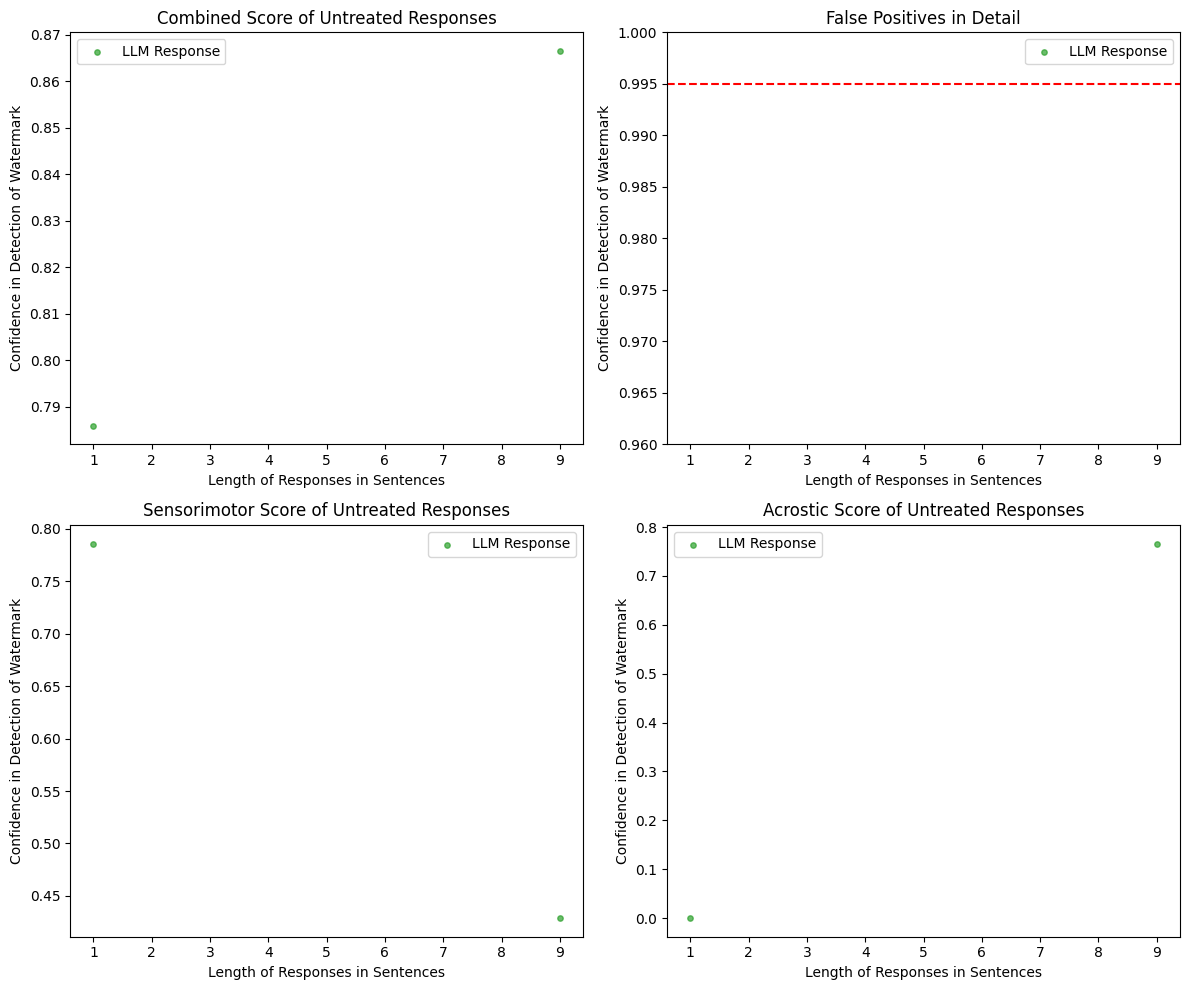

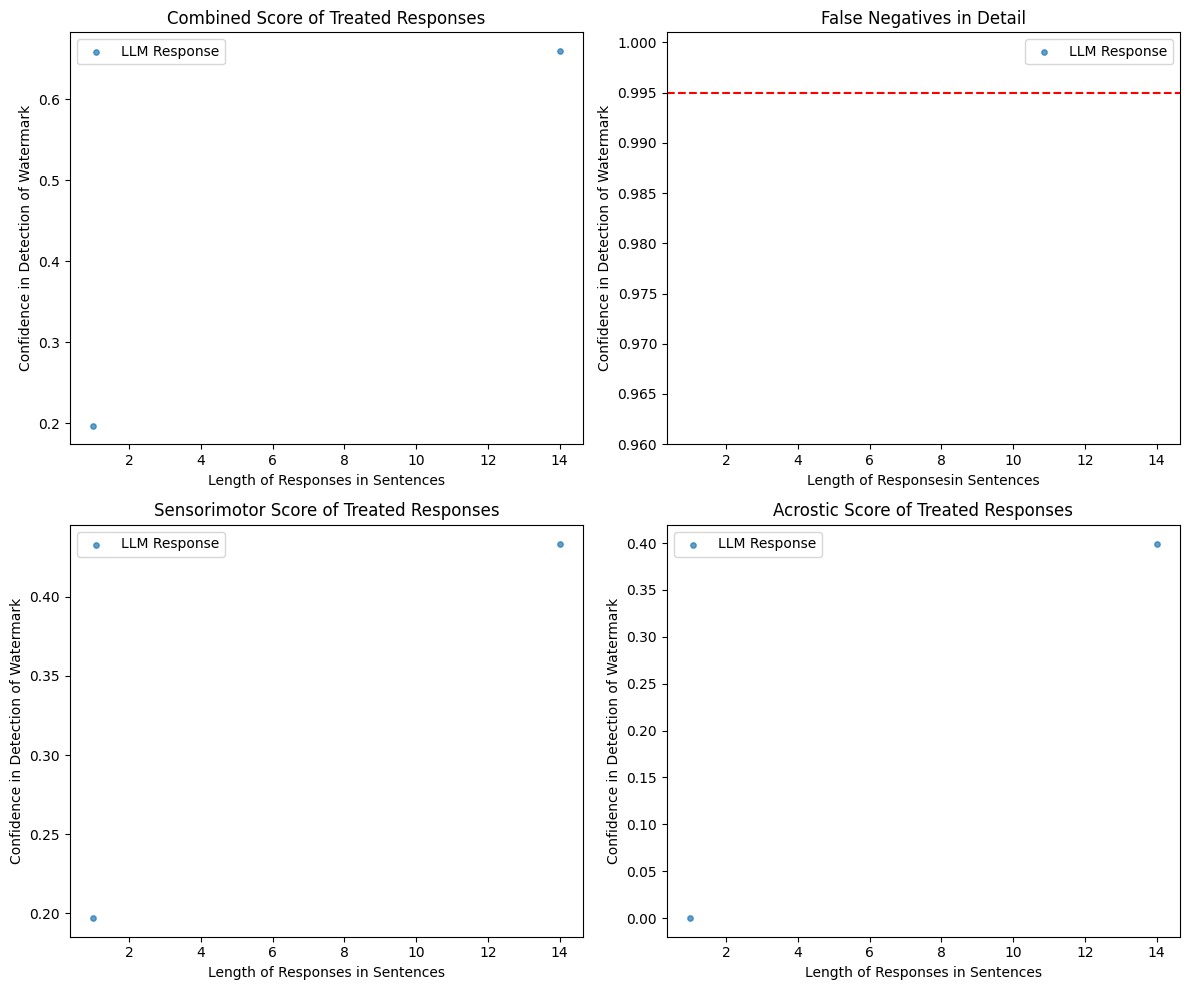

In [9]:
import csv
import ast
import matplotlib.pyplot as plt

# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_score9.csv"
# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

    # Read the data from the CSV file, convert string representations to lists
    data = [convert_to_list(value) for row in csv_reader for value in row]

# Combine each pair into a single row
scores = [(data[i], data[i + 1]) for i in range(0, len(data), 2)]
print(scores)



# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1
y_values1 = [1-item[0][0] for item in scores]
x_values1 = [item[0][3] for item in scores]
axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C2'], marker='o', label='LLM Response')
axs[0, 0].set_xlabel('Length of Responses in Sentences')
axs[0, 0].set_ylabel('Confidence in Detection of Watermark')
axs[0, 0].set_title('Combined Score of Untreated Responses')
axs[0, 0].legend()

# Subplot 2
y_values2 = [1-item[0][0] for item in scores]
x_values2 = [item[0][3] for item in scores]
axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C2'], marker='o', label='LLM Response')
axs[0, 1].set_xlabel('Length of Responses in Sentences')
axs[0, 1].set_ylabel('Confidence in Detection of Watermark')
axs[0, 1].set_title('False Positives in Detail')
axs[0, 1].legend()
axs[0, 1].set_ylim(0.96, 1)  # Set the y-axis limit for the lower part
axs[0, 1].axhline(y=0.995, color='red', linestyle='--', label='Red Line')

# Subplot 3
y_values3 = [1-item[0][1] for item in scores]
x_values3 = [item[0][3] for item in scores]
axs[1, 0].scatter(x_values3, y_values3, s=15, alpha=0.7, c=['C2'], marker='o', label='LLM Response')
axs[1, 0].set_xlabel('Length of Responses in Sentences')
axs[1, 0].set_ylabel('Confidence in Detection of Watermark')
axs[1, 0].set_title('Sensorimotor Score of Untreated Responses')
axs[1, 0].legend()

# Subplot 4
y_values4 = [1-item[0][2] for item in scores]
x_values4 = [item[0][3] for item in scores]
axs[1, 1].scatter(x_values4, y_values4, s=15, alpha=0.7, c=['C2'], marker='o', label='LLM Response')
axs[1, 1].set_xlabel('Length of Responses in Sentences')
axs[1, 1].set_ylabel('Confidence in Detection of Watermark')
axs[1, 1].set_title('Acrostic Score of Untreated Responses')
axs[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure
plt.show()




# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1
y_values1 = [1-item[1][0] for item in scores]
x_values1 = [item[1][3] for item in scores]
axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[0, 0].set_xlabel('Length of Responses in Sentences')
axs[0, 0].set_ylabel('Confidence in Detection of Watermark')
axs[0, 0].set_title('Combined Score of Treated Responses')
axs[0, 0].legend()

# Subplot 2
y_values2 = [1-item[1][0] for item in scores]
x_values2 = [item[1][3] for item in scores]
axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[0, 1].set_xlabel('Length of Responsesin Sentences')
axs[0, 1].set_ylabel('Confidence in Detection of Watermark')
axs[0, 1].set_title('False Negatives in Detail')
axs[0, 1].legend()
axs[0, 1].set_ylim(0.96, 1.001)  # Set the y-axis limit for the lower part
axs[0, 1].axhline(y=0.995, color='red', linestyle='--', label='Red Line')

# Subplot 3
y_values3 = [1-item[1][1] for item in scores]
x_values3 = [item[1][3] for item in scores]
axs[1, 0].scatter(x_values3, y_values3, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[1, 0].set_xlabel('Length of Responses in Sentences')
axs[1, 0].set_ylabel('Confidence in Detection of Watermark')
axs[1, 0].set_title('Sensorimotor Score of Treated Responses')
axs[1, 0].legend()

# Subplot 4
y_values4 = [1-item[1][2] for item in scores]
x_values4 = [item[1][3] for item in scores]
axs[1, 1].scatter(x_values4, y_values4, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[1, 1].set_xlabel('Length of Responses in Sentences')
axs[1, 1].set_ylabel('Confidence in Detection of Watermark')
axs[1, 1].set_title('Acrostic Score of Treated Responses')
axs[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure
plt.show()

b_both_TN 25
b_both_FP 1
w_both_TP 35
w_both_FN 2


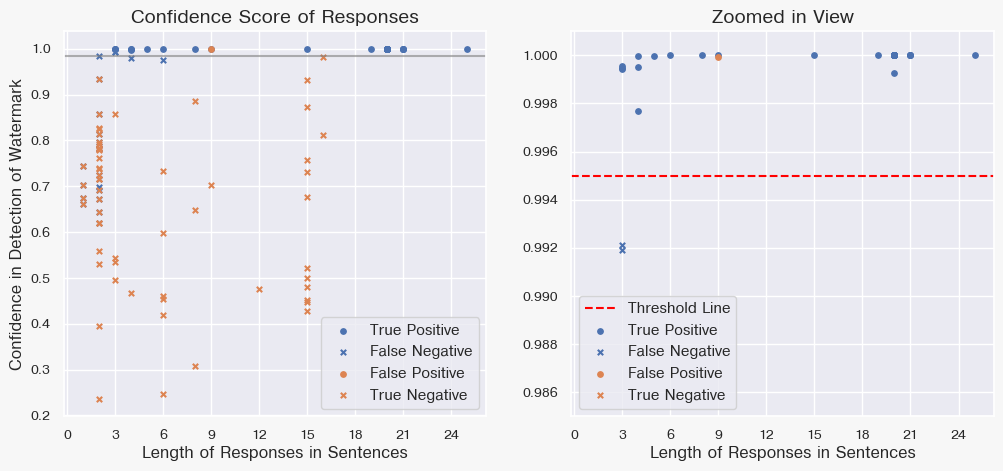

In [8]:
import csv
import ast
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_score8.csv"
# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

    # Read the data from the CSV file, convert string representations to lists
    data = [convert_to_list(value) for row in csv_reader for value in row]

# Combine each pair into a single row
scores = [(data[i], data[i + 1]) for i in range(0, len(data), 2)]
#print(scores)



# Define a function to plot with different markers based on condition
def plot_with_condition(ax, x_values, y_values, threshold=0.995, colour='C0'):
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    # Points above threshold
    ax.scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c=colour, marker='o', label='LLM Response (≥0.995)')
    # Points below threshold
    ax.scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c=colour, marker='x', label='LLM Response (<0.995)')

# Applying additional aesthetic improvements to the plots
# Set a style for the plots
import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# for ax in axs.flat:
#     ax.set_xlabel('Length of Responses in Sentences', fontsize=12)
#     ax.set_ylabel('Confidence in Detection of Watermark', fontsize=12)
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.set_facecolor('#f2f2f2')  # Apply the light gray background to each subplot
    

axs[0].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[0].set_ylabel('Confidence in Detection of Watermark', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[1].set_ylabel(' ', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Subplot 1
y_values1 = [1.0-item[1][0] for item in scores]
x_values1 = [item[1][3] for item in scores]

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_both_TP = 0
w_both_FN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_both_TP += 1
    else:
        if x_values[i] > 3:
            w_both_FN += 1

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='True Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='False Negative')



#axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')



y_values2 = [1.0-item[0][0] for item in scores]
x_values2 = [item[0][3] for item in scores]

#######################################uncomment to print values
#for i in range (0,60):
    #print(f'''&{y_values2[i]} & {y_values1[i]}''')


x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_both_FP = 0
b_both_TN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_both_FP += 1
    else:
        if x_values[i] > 3:
            b_both_TN += 1
# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='False Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='True Negative')


axs[0].set_title('Confidence Score of Responses', fontsize=14)
axs[0].legend()
axs[0].axhline(y=0.985, color='grey', linestyle='-', alpha=0.6)

# Subplot 2
axs[1].axhline(y=0.995, color='red', linestyle='--', label='Threshold Line')

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995


# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='True Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='False Negative')
#axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1].set_title('Zoomed in View', fontsize=14)
axs[1].legend()
axs[1].set_ylim(0.985, 1.001)

x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='False Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='True Negative')
axs[1].legend()

print(f'''b_both_TN {b_both_TN}''')
print(f'''b_both_FP {b_both_FP}''')
print(f'''w_both_TP {w_both_TP}''')
print(f'''w_both_FN {w_both_FN}''')

plt.savefig('paper_plot.png', dpi=300, bbox_inches='tight')

[([0.173401239922371, 0.18033728951926586, 0.9615384615384615, 2, 0], [0.008095692064743856, 0.10945375671533686, 0.07396449704142016, 3, 1]), ([0.5528075667495754, 0.9572838433968545, 0.5774750828218062, 15, 0], [8.088322321246105e-29, 0.06199434289624539, 1.3046871606951035e-27, 20, 19]), ([0.30796416356680484, 0.32028273010947705, 0.9615384615384615, 2, 0], [0.30796416356680484, 0.32028273010947705, 0.9615384615384615, 2, 0]), ([0.26599358934253925, 0.32362187249339414, 0.8219271067593517, 6, 0], [2.3256557008037786e-29, 0.017825389647927015, 1.3046871606951035e-27, 20, 19]), ([0.26963812351506783, 0.46692598786685857, 0.5774750828218062, 15, 0], [7.049453852192648e-28, 0.540317561524625, 1.3046871606951035e-27, 20, 19]), ([0.3271091925485308, 0.3401935602504721, 0.9615384615384615, 2, 0], [0.3271091925485308, 0.3401935602504721, 0.9615384615384615, 2, 0]), ([0.21951100790989175, 0.22829144822628744, 0.9615384615384615, 2, 0], [0.21951100790989175, 0.22829144822628744, 0.96153846153

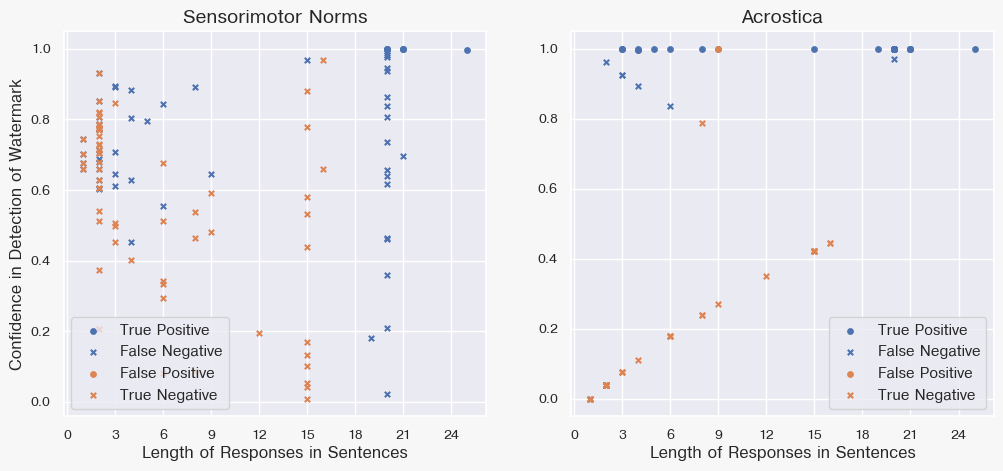

In [11]:
import csv
import ast
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_score8.csv"
# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

    # Read the data from the CSV file, convert string representations to lists
    data = [convert_to_list(value) for row in csv_reader for value in row]

# Combine each pair into a single row
scores = [(data[i], data[i + 1]) for i in range(0, len(data), 2)]
print(scores)



# Define a function to plot with different markers based on condition
def plot_with_condition(ax, x_values, y_values, threshold=0.995, colour='C0'):
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    # Points above threshold
    ax.scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c=colour, marker='o', label='LLM Response (≥0.995)')
    # Points below threshold
    ax.scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c=colour, marker='x', label='LLM Response (<0.995)')

# Applying additional aesthetic improvements to the plots
# Set a style for the plots
import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# for ax in axs.flat:
#     ax.set_xlabel('Length of Responses in Sentences', fontsize=12)
#     ax.set_ylabel('Confidence in Detection of Watermark', fontsize=12)
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.set_facecolor('#f2f2f2')  # Apply the light gray background to each subplot
    

axs[0].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[0].set_ylabel('Confidence in Detection of Watermark', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[1].set_ylabel(' ', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Subplot 1
y_values1 = [1-item[1][1] for item in scores]
x_values1 = [item[1][3] for item in scores]
x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_senso_TP = 0
w_senso_FN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_senso_TP += 1
    else:
        if x_values[i] > 3:
            w_senso_FN += 1
       

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='True Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='False Negative')



#axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')



y_values2 = [1-item[0][1] for item in scores]
x_values2 = [item[0][3] for item in scores]
x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_senso_FP = 0
b_senso_TN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_senso_FP += 1
    else:
        if x_values[i] > 3:
            b_senso_TN += 1

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='False Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='True Negative')





axs[0].set_title('Sensorimotor Norms', fontsize=14)
axs[0].legend()
#axs[0].axhline(y=0.985, color='grey', linestyle='-', alpha=0.6)

# Subplot 2
#axs[1].axhline(y=0.995, color='red', linestyle='--', label='Threshold Line')

y_values1 = [1-item[1][2] for item in scores]
x_values1 = [item[1][3] for item in scores]
x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_acro_TP = 0
w_acro_FN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_acro_TP += 1
    else:
        if x_values[i] > 3:
            w_acro_FN += 1

# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='True Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='False Negative')
#axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1].set_title('Acrostica', fontsize=14)
axs[1].legend()
#axs[1].set_ylim(0.985, 1.001)

y_values2 = [1-item[0][2] for item in scores]
x_values2 = [item[0][3] for item in scores]
x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_acro_FP = 0
b_acro_TN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_acro_FP += 1
    else:
        if x_values[i] > 3:
            b_acro_TN += 1
            
# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='False Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='True Negative')
axs[1].legend()


print(f'''b_senso_TN {b_senso_TN}''')
print(f'''b_senso_FP {b_senso_FP}''')
print(f'''w_senso_TP {w_senso_TP}''')
print(f'''w_senso_FN {w_senso_FN}''')
print(f'''b_acro_TN {b_acro_TN}''')
print(f'''b_acro_FP {b_acro_FP}''')
print(f'''w_acro_TP {w_acro_TP}''')
print(f'''w_acro_FN {w_acro_FN}''')

plt.savefig('ablation.png', dpi=300, bbox_inches='tight')

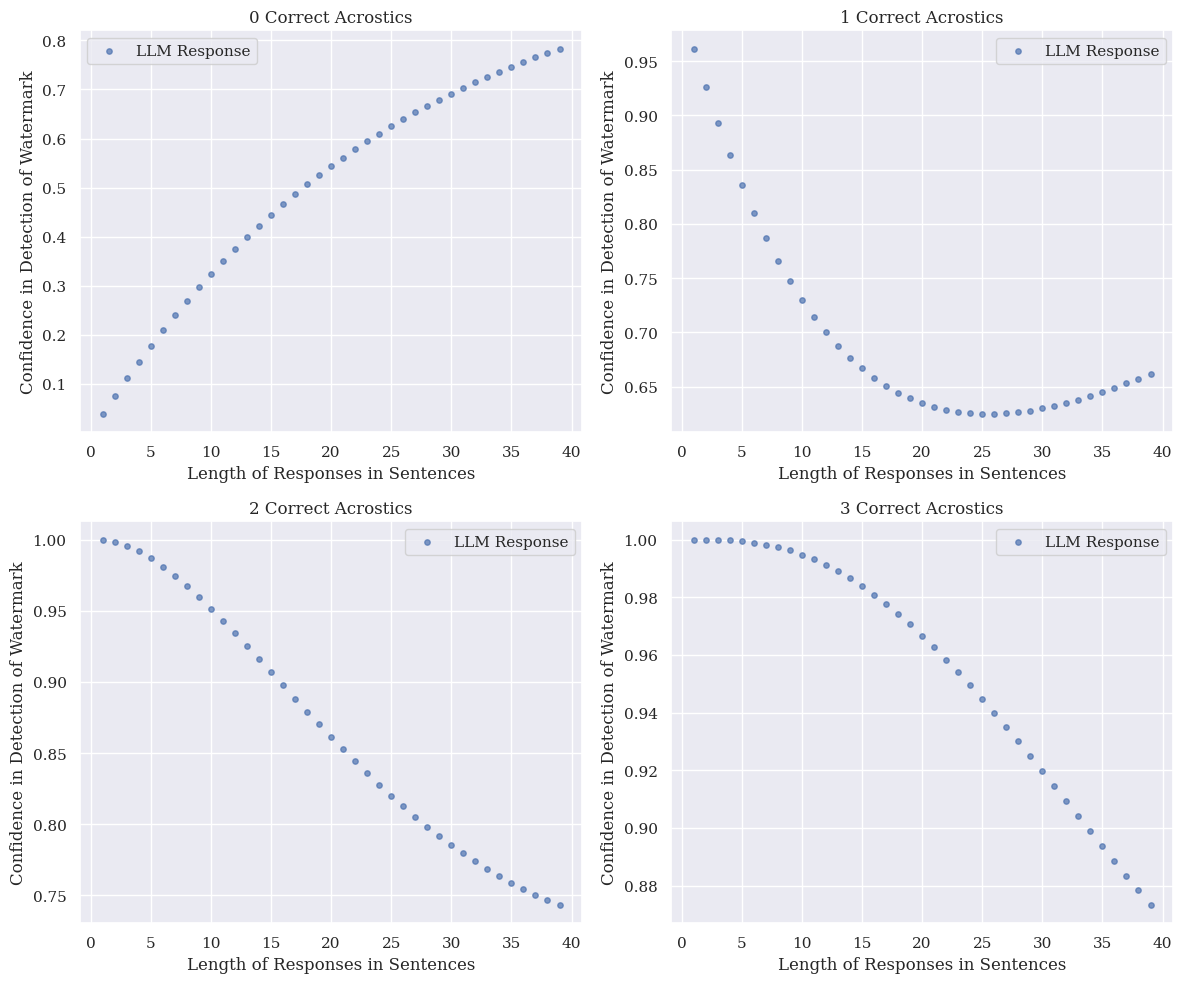

In [81]:
def probability_of_acrosticon(num_sentences_starting_with_A, total_sentences, probability_of_A=1/26):

        # Calculate the binomial probability
        return binom.pmf(num_sentences_starting_with_A, total_sentences, probability_of_A)


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1
x_values1 = range(1,40)
y_values1 = []
for x in x_values1:
        y_values1.append(1-probability_of_acrosticon(0,x))
axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[0, 0].set_xlabel('Length of Responses in Sentences')
axs[0, 0].set_ylabel('Confidence in Detection of Watermark')
axs[0, 0].set_title('0 Correct Acrostics')
axs[0, 0].legend()

# Subplot 2
x_values2 = range(1,40)
y_values2 = []
for x in x_values2:
        y_values2.append(1-probability_of_acrosticon(1,x))
axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[0, 1].set_xlabel('Length of Responses in Sentences')
axs[0, 1].set_ylabel('Confidence in Detection of Watermark')
axs[0, 1].set_title('1 Correct Acrostics')
axs[0, 1].legend()

# Subplot 3
x_values3 = range(1,40)
y_values3 = []
for x in x_values3:
        y_values3.append(1-probability_of_acrosticon(2,x))
axs[1, 0].scatter(x_values3, y_values3, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[1, 0].set_xlabel('Length of Responses in Sentences')
axs[1, 0].set_ylabel('Confidence in Detection of Watermark')
axs[1, 0].set_title('2 Correct Acrostics')
axs[1, 0].legend()

# Subplot 4
x_values4 = range(1,40)
y_values4 = []
for x in x_values4:
        y_values4.append(1-probability_of_acrosticon(3,x))
axs[1, 1].scatter(x_values4, y_values4, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[1, 1].set_xlabel('Length of Responses in Sentences')
axs[1, 1].set_ylabel('Confidence in Detection of Watermark')
axs[1, 1].set_title('3 Correct Acrostics')
axs[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure
plt.show()


In [12]:
import csv
from googletrans import Translator

# Function to translate text
def translate_text(text, target_language='en'):
    if not text:
        return ""  # Return empty string if text is None or empty
    try:
        translator = Translator()
        translation = translator.translate(text, dest=target_language)
        return translation.text
    except Exception as e:
        print(f"Error during translation: {e}")
        return text  # Return the original text if translation fails

# Specify the file name
file_name = "output_gen6.csv"

# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object and convert it to a list
    output_gen = list(csv.reader(csv_file))

# Example usage
translations = []
for text in output_gen:
    # Assuming text[2] is the column with the text to be translated
    # Check if text[2] exists and is not empty
    if len(text) > 2 and text[2]:
        translated_text_watermark = translate_text(text[2], 'es')  # Translate to Spanish
        #translated_text_watermark = translate_text(translated_text_watermark, 'en')  # Translate back to English

    else:
        translated_text_watermark = ""

    if len(text) > 2 and text[1]:
        translated_text_base = translate_text(text[1], 'es')  # Translate to Spanish
        #translated_text_base = translate_text(translated_text_base, 'en')  # Translate back to English
    else:
        translated_text_base = ""

    if len(text) > 2 and text[0]:
        prompt = text[0]
    else:
        prompt = ""

    
    translations.append([prompt,translated_text_base,translated_text_watermark])

Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType


In [13]:
import csv

# Specify the file name
file_name = "output_translation_genX.csv"

# Open the file in write mode with newline='' to ensure correct line endings
with open(file_name, 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the data to the CSV file
    csv_writer.writerows(translations)

In [14]:
import spacy
import hashlib
from scipy.stats import zscore
from scipy.stats import norm
from itertools import permutations
from collections import Counter
import math
import modules.shared as shared

from scipy.stats import binom

# def secure_hash_to_numbers(input_string, range_list):

    
#     nlp = spacy.load("en_core_web_sm")

#     doc = nlp(input_string)

    
#     core = [token.lemma_ for token in doc if not token.is_stop]

#     core_str = " ".join(core)
    
#     hashed_bytes = hashlib.sha256(core_str.encode()).digest()
    
    

#     num_numbers = len(range_list)
#     hashed_integers = [int.from_bytes(hashed_bytes[i:i+4], byteorder='big') for i in range(0, num_numbers * 4, 4)]

#     #cast hash to integer, then use modulo to map to required range
   
#     result_numbers = []
#     for i in range(num_numbers):
#         range_min, range_max = range_list[i]
#         integer = hashed_integers[i]
#         mapped_number = (integer % (range_max - range_min + 1)) + range_min
#         result_numbers.append(mapped_number)
    
#     return result_numbers


# Load the English language model
nlp = spacy.load("en_core_web_sm")

def split_into_sentences(text):
    doc = nlp(text)
    sentences = []
    current_sentence = []

    for token in doc:
        current_sentence.append(token.text)
        if token.text in (".", "?", "!"):
            sentences.append(" ".join(current_sentence))
            current_sentence = []

    # Add the last sentence if not followed by a punctuation mark
    if current_sentence:
        sentences.append(" ".join(current_sentence))

    return sentences

def get_words_in_sentence(sentence):
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    return words

import pandas as pd
df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)  #the header is in the first row

shared.sensorimotor = df.set_index('Word').T.to_dict('dict')
shared.classes = ['Auditory.mean', 'Gustatory.mean','Haptic.mean','Interoceptive.mean','Olfactory.mean','Visual.mean','Foot_leg.mean','Hand_arm.mean','Head.mean','Mouth.mean','Torso.mean']

mean_value = [1.51,0.32,1.07,1.03,0.39,2.90,0.81,1.45,2.28,1.26,0.82]
std_deviation = [0.99,0.70,0.93,0.88,0.62,0.90,0.75,0.91,0.72,0.90,0.67]


def calculate_probs(reply):
    z_scores = []
    probabilities = []
    correct_acrosticons = 0
    old_class = 0

    sentences = split_into_sentences(reply)
    for idx, sentence in enumerate(sentences, start=1):

        if idx > 1:
            if(chr(ord('A') + generated_numbers[1]) == sentence[:1]):
                correct_acrosticons += 1

        range_list = [(0, 10), (0, 25)] 
        generated_numbers = secure_hash_to_numbers(sentence, range_list)


        sum_of_word_mean = 0
        valid_words = 0
        words = get_words_in_sentence(sentence)
        for word in words:
            if word.upper() in shared.sensorimotor:
                valid_words += 1
                sum_of_word_mean += shared.sensorimotor[word.upper()][shared.classes[old_class]]

        if(valid_words > 0):
            sentence_value = sum_of_word_mean/valid_words

            # Calculate Z-score for the new data point
            z_score = (sentence_value - mean_value[old_class]) / std_deviation[old_class]
        else:
            z_score = 0

        # Calculate the probability using the cumulative distribution function (CDF)
        probabilities.append(1-norm.cdf(z_score))
        z_scores.append(z_score)

        old_class = generated_numbers[0]



    def probability_of_acrosticon(num_sentences_starting_with_A, total_sentences, probability_of_A=1/26):

        # Calculate the binomial probability
        return binom.pmf(num_sentences_starting_with_A, total_sentences, probability_of_A)


    acrosticon_restult = probability_of_acrosticon(correct_acrosticons, len(sentences)-1)
    #print(f"The Acrosticon probability is: {acrosticon_restult} for {correct_acrosticons} correct acrosticons in {len(sentences)-1} valid sentences.")

    # Example usage:
    stouffer_result = 1-norm.cdf(sum(z_scores)/ math.sqrt(len(probabilities)))
    #print(probabilities)
    #print(f"The Stouffer's method combinded z_score is the probability of: {stouffer_result}")
    #print(f"The total probability is: {stouffer_result*acrosticon_restult}")

    #return stouffer_result*acrosticon_restult, len(sentences), correct_acrosticons
    return stouffer_result*acrosticon_restult, stouffer_result, acrosticon_restult, len(sentences), correct_acrosticons

scores_translation = []


for tuple in translations:
    score_base, stouffer_result_base, acrosticon_restult_base, len_base, acros_base = calculate_probs(tuple[1])
    score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark = calculate_probs(tuple[2])

    scores_translation.append([[score_base,stouffer_result_base, acrosticon_restult_base,len_base,acros_base],[score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark]])




    

In [15]:
# Specify the file name
file_name = "output_translation_scoreX.csv"

# Open the file in write mode with newline='' to ensure correct line endings
with open(file_name, 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the data to the CSV file
    csv_writer.writerows(scores_translation)

In [8]:
import matplotlib.pyplot as plt

# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_translation2.csv"
file_name = "output_translation2.csv"  # replace with your file name
scores_translation = []

# Open the file and read the contents
with open(file_name, 'r') as file:
    csv_reader = csv.reader(file)
    
    for row in csv_reader:
        # Convert each element in the row to float or int as appropriate
        data_row = [float(item) if '.' in item else int(item) for item in row]
        scores_translation.append(data_row)

# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1
y_values1 = [1-item[0] for item in scores_translation]
x_values1 = [item[3] for item in scores_translation]
axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[0, 0].set_xlabel('Length of Responses in Sentences')
axs[0, 0].set_ylabel('Confidence in Detection of Watermark')
axs[0, 0].set_title('Combined Score of Treated Attacked Responses')
axs[0, 0].axhline(y=0.995, color='red', linestyle='--', label='Red Line')
axs[0, 0].legend()

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
tw_both_TP = 0
tw_both_FN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            tw_both_TP += 1
    else:
        if x_values[i] > 3:
            tw_both_FN += 1



# Subplot 2
y_values2 = [1-item[0] for item in scores_translation]
x_values2 = [item[3] for item in scores_translation]
axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[0, 1].set_xlabel('Length of Responses in Sentences')
axs[0, 1].set_ylabel('Confidence in Detection of Watermark')
axs[0, 1].set_title('False Negatives in Detail')
axs[0, 1].legend()
axs[0, 1].set_ylim(0.96, 1.001)  # Set the y-axis limit for the lower part
axs[0, 1].axhline(y=0.995, color='red', linestyle='--', label='Red Line')




# Subplot 3
y_values3 = [1-item[1] for item in scores_translation]
x_values3 = [item[3] for item in scores_translation]
axs[1, 0].scatter(x_values3, y_values3, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1, 0].set_xlabel('Length of Responses in Sentences')
axs[1, 0].set_ylabel('Confidence in Detection of Watermark')
axs[1, 0].set_title('Sensorimotor Score of Treated Attacked Responses')
axs[1, 0].legend()

x_values = np.array(x_values3)
y_values = np.array(y_values3)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
tw_senso_TP = 0
tw_senso_FN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            tw_senso_TP += 1
    else:
        if x_values[i] > 3:
            tw_senso_FN += 1

# Subplot 4
y_values4 = [1-item[2] for item in scores_translation]
x_values4 = [item[3] for item in scores_translation]
axs[1, 1].scatter(x_values4, y_values4, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1, 1].set_xlabel('Length of Responses in Sentences')
axs[1, 1].set_ylabel('Confidence in Detection of Watermark')
axs[1, 1].set_title('Acrostic Score of Treated Attacked Responses')
axs[1, 1].legend()


x_values = np.array(x_values4)
y_values = np.array(y_values4)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
tw_acro_TP = 0
tw_acro_FN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            tw_acro_TP += 1
    else:
        if x_values[i] > 3:
            tw_acro_FN += 1

print(f'''tw_both_TP {tw_both_TP}''')
print(f'''tw_both_FN {tw_both_FN}''')
print(f'''tw_senso_TP {tw_senso_TP}''')
print(f'''tw_senso_FN {tw_senso_FN}''')
print(f'''tw_acro_TP {tw_acro_TP}''')
print(f'''tw_acro_FN {tw_acro_FN}''')

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'output_translation2.csv'

[[0.5297548768676754, 0.5297548768676754, 1.0, 1, 0], [0.5, 0.5, 1.0, 1, 0], [0.16313687894503626, 0.644985130122344, 0.2529312248083791, 10, 1], [0.0074157060185854155, 0.152459117397856, 0.0486406201554575, 11, 2], [0.4815686641915553, 0.5008314107592176, 0.9615384615384615, 2, 0], [0.3454519329611654, 0.37364081069079647, 0.9245562130177515, 3, 0], [0.11989614467796823, 0.14587199240902038, 0.8219271067593517, 6, 0], [0.48660592278700776, 0.640340197759805, 0.7599178132020633, 8, 0], [0.7973759062443191, 0.7973759062443191, 1.0, 1, 0], [0.7086198848130916, 0.8289850380348087, 0.8548041910297263, 5, 0], [0.12287687812504762, 0.5774913887787122, 0.2127769876965777, 8, 1], [0.5401003058225788, 0.5401003058225788, 1.0, 1, 0], [0.4936081321406111, 0.5133524574262356, 0.9615384615384615, 2, 0], [0.6035806721143874, 0.6035806721143874, 1.0, 1, 0], [0.5828720919037046, 0.7670199089657581, 0.7599178132020633, 8, 0], [0.7462422571933712, 0.7462422571933712, 1.0, 1, 0], [0.5576512335318943, 0.

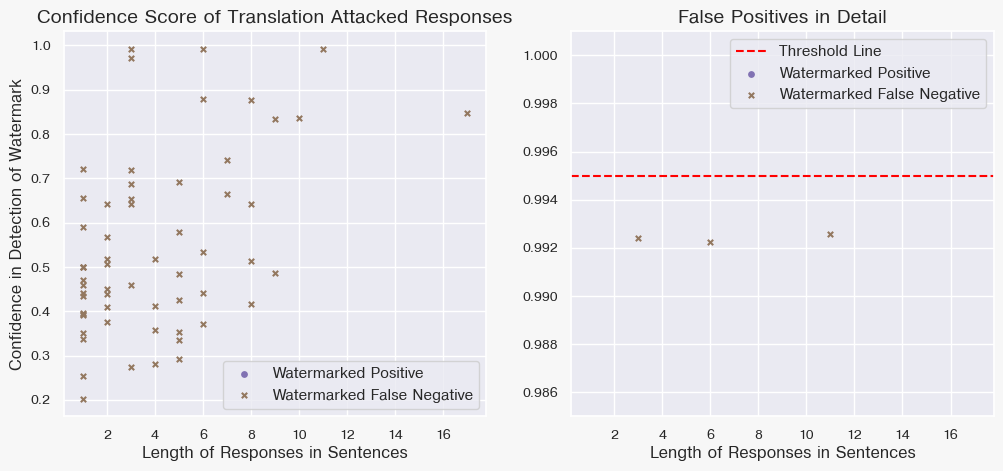

In [10]:
import csv
import ast
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


import ast  # Import the ast module

scores = []

# Assuming 'file' is your file object
with open('output_score2.csv', 'r') as file:
    csv_reader = csv.reader(file)

    for row in csv_reader:
        # Check if the row looks like a string representation of a list
        if row[0].startswith('[') and row[0].endswith(']'):
            # Use ast.literal_eval to safely evaluate the string as a list
            data_row = ast.literal_eval(row[0])
        else:
            # For rows that do not contain a string representation of a list
            # Convert each element in the row to float or int as appropriate
            data_row = [float(item) if '.' in item else int(item) for item in row]
        
        scores.append(data_row)

print(scores)



# Define a function to plot with different markers based on condition
def plot_with_condition(ax, x_values, y_values, threshold=0.995, colour='C0'):
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    # Points above threshold
    ax.scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c=colour, marker='o', label='LLM Response (≥0.995)')
    # Points below threshold
    ax.scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c=colour, marker='x', label='LLM Response (<0.995)')

# Applying additional aesthetic improvements to the plots
# Set a style for the plots
import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# for ax in axs.flat:
#     ax.set_xlabel('Length of Responses in Sentences', fontsize=12)
#     ax.set_ylabel('Confidence in Detection of Watermark', fontsize=12)
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.set_facecolor('#f2f2f2')  # Apply the light gray background to each subplot
    

axs[0].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[0].set_ylabel('Confidence in Detection of Watermark', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[1].set_ylabel(' ', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Subplot 1
y_values1 = [1-item[:][0] for item in scores]
x_values1 = [item[:][3] for item in scores]
x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C4', marker='o', label='Watermarked Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C5', marker='x', label='Watermarked False Negative')



#axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')



axs[0].set_title('Confidence Score of Translation Attacked Responses', fontsize=14)
axs[0].legend()
#axs[0].axhline(y=0.985, color='grey', linestyle='-', alpha=0.6)

# Subplot 2
axs[1].axhline(y=0.995, color='red', linestyle='--', label='Threshold Line')

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C4', marker='o', label='Watermarked Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C5', marker='x', label='Watermarked False Negative')
#axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1].set_title('False Positives in Detail', fontsize=14)
axs[1].legend()
axs[1].set_ylim(0.985, 1.001)


axs[1].legend()

plt.savefig('oldhash.png', dpi=300, bbox_inches='tight')

b_both_TN 70
b_both_FP 6
w_both_TP 16
w_both_FN 56


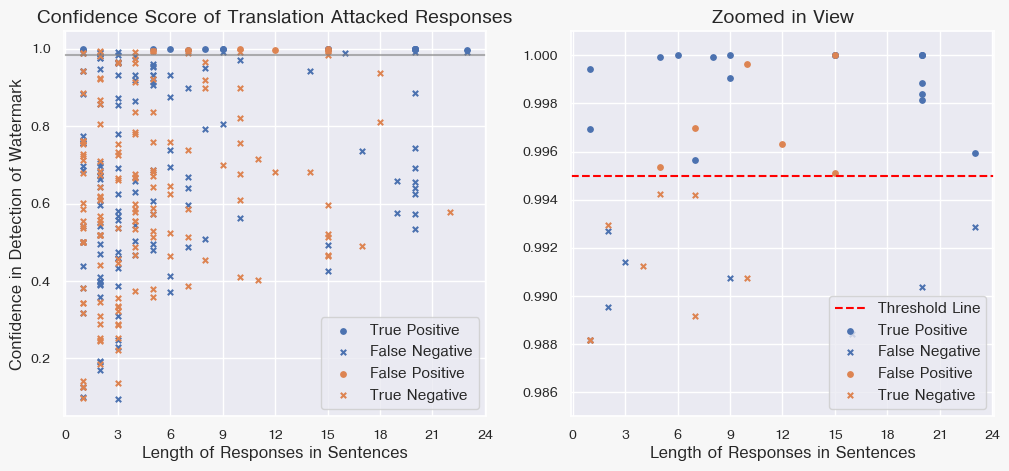

In [16]:
import csv
import ast
#%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_translation_scoreX.csv"
# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

    # Read the data from the CSV file, convert string representations to lists
    data = [convert_to_list(value) for row in csv_reader for value in row]

# Combine each pair into a single row
scores = [(data[i], data[i + 1]) for i in range(0, len(data), 2)]
#print(scores)



# Define a function to plot with different markers based on condition
def plot_with_condition(ax, x_values, y_values, threshold=0.995, colour='C0'):
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    # Points above threshold
    ax.scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c=colour, marker='o', label='LLM Response (≥0.995)')
    # Points below threshold
    ax.scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c=colour, marker='x', label='LLM Response (<0.995)')

# Applying additional aesthetic improvements to the plots
# Set a style for the plots
import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# for ax in axs.flat:
#     ax.set_xlabel('Length of Responses in Sentences', fontsize=12)
#     ax.set_ylabel('Confidence in Detection of Watermark', fontsize=12)
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.set_facecolor('#f2f2f2')  # Apply the light gray background to each subplot
    

axs[0].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[0].set_ylabel('Confidence in Detection of Watermark', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[1].set_ylabel(' ', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Subplot 1
y_values1 = [1.0-item[1][0] for item in scores]
x_values1 = [item[1][3] for item in scores]

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_both_TP = 0
w_both_FN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_both_TP += 1
    else:
        if x_values[i] > 3:
            w_both_FN += 1

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='True Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='False Negative')



#axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')



y_values2 = [1.0-item[0][0] for item in scores]
x_values2 = [item[0][3] for item in scores]

#######################################uncomment to print values
#for i in range (0,60):
    #print(f'''&{y_values2[i]} & {y_values1[i]}''')


x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_both_FP = 0
b_both_TN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_both_FP += 1
    else:
        if x_values[i] > 3:
            b_both_TN += 1
# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='False Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='True Negative')


axs[0].set_title('Confidence Score of Translation Attacked Responses', fontsize=14)
axs[0].legend()
axs[0].axhline(y=0.985, color='grey', linestyle='-', alpha=0.6)

# Subplot 2
axs[1].axhline(y=0.995, color='red', linestyle='--', label='Threshold Line')

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995


# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='True Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='False Negative')
#axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1].set_title('Zoomed in View', fontsize=14)
axs[1].legend()
axs[1].set_ylim(0.985, 1.001)

x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='False Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='True Negative')
axs[1].legend()

print(f'''b_both_TN {b_both_TN}''')
print(f'''b_both_FP {b_both_FP}''')
print(f'''w_both_TP {w_both_TP}''')
print(f'''w_both_FN {w_both_FN}''')

plt.savefig('paper_plot_translation.png', dpi=300, bbox_inches='tight')

[([0.5297548768676754, 0.5297548768676754, 1.0, 1, 0], [0.3281204982094562, 0.3281204982094562, 1.0, 1, 0]), ([0.6166518151174941, 0.6669706032310816, 0.9245562130177515, 3, 0], [8.553158817654539e-11, 0.18603365304089636, 4.5976406299855176e-10, 20, 10]), ([0.519091104498668, 0.5839068961707898, 0.8889963586709148, 4, 0], [0.2906362734298562, 0.30226172436705045, 0.9615384615384615, 2, 0]), ([0.594967782715279, 0.6187664940238902, 0.9615384615384615, 2, 0], [4.595478481516161e-13, 0.03054118608804135, 1.504682387995258e-11, 20, 11]), ([0.4929113609549464, 0.53313292800887, 0.9245562130177515, 3, 0], [0.22653737190337375, 0.22653737190337375, 1.0, 1, 0]), ([0.6216508991115235, 0.6216508991115235, 1.0, 1, 0], [0.0003560309241830312, 0.35194742151679437, 0.0010116025929345867, 7, 3]), ([0.5350870127442552, 0.5350870127442552, 1.0, 1, 0], [0.0043513289140891835, 0.3308785595389778, 0.013150833708149628, 6, 2]), ([0.6626609602814836, 0.6626609602814836, 1.0, 1, 0], [0.6191067768285119, 0.6

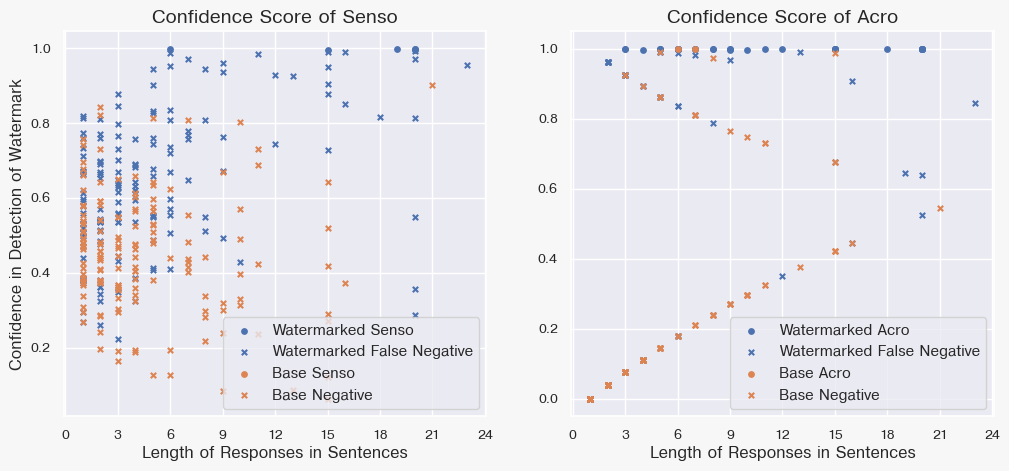

In [1]:
import csv
import ast
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_translation_score6.csv"
# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

    # Read the data from the CSV file, convert string representations to lists
    data = [convert_to_list(value) for row in csv_reader for value in row]

# Combine each pair into a single row
scores = [(data[i], data[i + 1]) for i in range(0, len(data), 2)]
print(scores)



# Define a function to plot with different markers based on condition
def plot_with_condition(ax, x_values, y_values, threshold=0.995, colour='C0'):
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    # Points above threshold
    ax.scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c=colour, marker='o', label='LLM Response (≥0.995)')
    # Points below threshold
    ax.scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c=colour, marker='x', label='LLM Response (<0.995)')

# Applying additional aesthetic improvements to the plots
# Set a style for the plots
import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# for ax in axs.flat:
#     ax.set_xlabel('Length of Responses in Sentences', fontsize=12)
#     ax.set_ylabel('Confidence in Detection of Watermark', fontsize=12)
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.set_facecolor('#f2f2f2')  # Apply the light gray background to each subplot
    

axs[0].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[0].set_ylabel('Confidence in Detection of Watermark', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[1].set_ylabel(' ', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Subplot 1
y_values1 = [1-item[1][1] for item in scores]
x_values1 = [item[1][3] for item in scores]
x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_senso_TP = 0
w_senso_FN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_senso_TP += 1
    else:
        if x_values[i] > 3:
            w_senso_FN += 1
       

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='Watermarked Senso')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='Watermarked False Negative')



#axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')



y_values2 = [1-item[0][1] for item in scores]
x_values2 = [item[0][3] for item in scores]
x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_senso_FP = 0
b_senso_TN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_senso_FP += 1
    else:
        if x_values[i] > 3:
            b_senso_TN += 1

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='Base Senso')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='Base Negative')





axs[0].set_title('Confidence Score of Senso', fontsize=14)
axs[0].legend()
#axs[0].axhline(y=0.985, color='grey', linestyle='-', alpha=0.6)

# Subplot 2
#axs[1].axhline(y=0.995, color='red', linestyle='--', label='Threshold Line')

y_values1 = [1-item[1][2] for item in scores]
x_values1 = [item[1][3] for item in scores]
x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_acro_TP = 0
w_acro_FN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_acro_TP += 1
    else:
        if x_values[i] > 3:
            w_acro_FN += 1

# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='Watermarked Acro')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='Watermarked False Negative')
#axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1].set_title('Confidence Score of Acro', fontsize=14)
axs[1].legend()
#axs[1].set_ylim(0.985, 1.001)

y_values2 = [1-item[0][2] for item in scores]
x_values2 = [item[0][3] for item in scores]
x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_acro_FP = 0
b_acro_TN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_acro_FP += 1
    else:
        if x_values[i] > 3:
            b_acro_TN += 1
            
# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='Base Acro')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='Base Negative')
axs[1].legend()


print(f'''b_senso_TN {b_senso_TN}''')
print(f'''b_senso_FP {b_senso_FP}''')
print(f'''w_senso_TP {w_senso_TP}''')
print(f'''w_senso_FN {w_senso_FN}''')
print(f'''b_acro_TN {b_acro_TN}''')
print(f'''b_acro_FP {b_acro_FP}''')
print(f'''w_acro_TP {w_acro_TP}''')
print(f'''w_acro_FN {w_acro_FN}''')

#plt.savefig('ablation.png', dpi=300, bbox_inches='tight')

In [8]:

prompts = [\
    "How do I write a good paper?"
    #"What is a watermark?"
    #"What is motorsports, is it a real sport?",
]



results = []


for prompt in prompts:
#prompt = "What is the capital of France?"
    question = f'''<|im_start|>system
You are a helpful assistant, who always provide explanation. Don't enumerate anwsers, talk for the user, write links or urls or use numbers.<|im_end|>
<|im_start|>user
{prompt}<|im_end|>
<|im_start>assistant
'''

    generate_params = {
        'max_new_tokens' : 200,
        'add_bos_token' : False,
        'truncation_length' : 4096,
        'custom_stopping_strings' : ["### Human:", "Human:", "user:", "Q:","<|im_end|>","<|im_start|>system"],
        'ban_eos_token' : False,
        'skip_special_tokens' : False,
        'do_sample': True,
        'temperature': 0.7,
        'top_p': 0.95,
        'typical_p': 1,
        'repetition_penalty': 1.10,
        'encoder_repetition_penalty': 1,
        'top_k': 40,
        'num_beams': 1,
        'penalty_alpha': 0,
        'min_length': 0,
        'length_penalty': 1,
        'no_repeat_ngram_size': 0,
        'early_stopping': False,
        'seed' : 0,
    }

    #no watermark
    shared.delta_char = 0.0
    shared.delta_first = 0.0
    shared.secret_key = [0,0]
    done = False
    reply_base = ""
    reply_current = ""
    current_question = question
    shared.new_sentence = False
    shared.delta_senso = 0
    shared.start = 0
    # i = 0
    # while (done is not True and i < 4):
    #     reply_current, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

    #     last_sentence = get_last_sentence(reply_current)
    #     #print("------------------found end of sentence, last sentence is:")
    #     #print(f'''[{reply_current}]''')
    #     shared.secret_key = secure_hash_to_numbers(last_sentence,[(0, 10), (0, 25)])
    #     shared.new_sentence = True
    #     shared.start = 0
    #     reply_base += reply_current
    #     current_question = f'''{current_question}{reply_current}'''
    #     i+=1
    reply_base, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

    #only senso
    shared.delta_char = 2.5#2.5
    shared.delta_first = 0.0#50
    shared.secret_key = [0,0]
    done = False
    reply_senso = ""
    reply_current = ""
    current_question = question
    shared.new_sentence = False
    shared.delta_senso = 0
    shared.start = 0
    # i = 0
    # while (done is not True and i < 4):
    #     reply_current, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

    #     last_sentence = get_last_sentence(reply_current)
    #     #print("------------------found end of sentence, last sentence is:")
    #     #print(f'''[{reply_current}]''')
    #     shared.secret_key = secure_hash_to_numbers(last_sentence,[(0, 10), (0, 25)])
    #     shared.new_sentence = True
    #     shared.start = 0
    #     reply_senso += reply_current
    #     current_question = f'''{current_question}{reply_current}'''
    #     i+=1

    reply_senso, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')
    
    #only acro
    shared.delta_char = 0.0#2.5
    shared.delta_first = 20.0#50
    shared.secret_key = [0,0]
    done = False
    reply_acro = ""
    reply_current = ""
    current_question = question
    shared.new_sentence = False
    shared.delta_senso = 0
    shared.start = 0
    # i = 0
    # while (done is not True and i < 4):
    #     reply_current, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

    #     last_sentence = get_last_sentence(reply_current)
    #     #print("------------------found end of sentence, last sentence is:")
    #     #print(f'''[{reply_current}]''')
    #     shared.secret_key = secure_hash_to_numbers(last_sentence,[(0, 10), (0, 25)])
    #     shared.new_sentence = True
    #     shared.start = 0
    #     reply_acro += reply_current
    #     current_question = f'''{current_question}{reply_current}'''
    #     i+=1
    reply_acro, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

    #both
    shared.delta_char = 2.5#2.5
    shared.delta_first = 20.0#50
    shared.secret_key = [0,0]
    done = False
    reply_watermark = ""
    reply_current = ""
    current_question = question
    shared.new_sentence = False
    shared.delta_senso = 0
    shared.start = 0
    # i = 0
    # while (done is not True and i < 4):
    #     reply_current, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

    #     last_sentence = get_last_sentence(reply_current)
    #     #print("------------------found end of sentence, last sentence is:")
    #     #print(f'''[{reply_current}]''')
    #     shared.secret_key = secure_hash_to_numbers(last_sentence,[(0, 10), (0, 25)])
    #     shared.new_sentence = True
    #     shared.start = 0
    #     reply_watermark += reply_current
    #     current_question = f'''{current_question}{reply_current}'''
    #     i+=1
    reply_watermark, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')


    #results.append([prompt,reply_base,reply_watermark])
    results.append([prompt,reply_base,reply_senso,reply_acro,reply_watermark])


    #reply_watermark = generate_reply(question+reply_watermark, generate_params, eos_token='<|im_end|>')
    print(prompt)
    print(f'''[{reply_base}]''')
    print(f'''[{reply_senso}]''')
    print(f'''[{reply_acro}]''')
    print(f'''[{reply_watermark}]''')

Output generated in 1.04 seconds (11.58 tokens/s, 12 tokens, context 84, seed 0)
Output generated in 1.40 seconds (13.56 tokens/s, 19 tokens, context 96, seed 0)
Output generated in 1.45 seconds (14.52 tokens/s, 21 tokens, context 115, seed 0)
Output generated in 1.46 seconds (13.70 tokens/s, 20 tokens, context 135, seed 0)
Output generated in 0.99 seconds (12.15 tokens/s, 12 tokens, context 84, seed 0)
Output generated in 1.81 seconds (14.91 tokens/s, 27 tokens, context 96, seed 0)
Output generated in 1.69 seconds (14.81 tokens/s, 25 tokens, context 123, seed 0)
Output generated in 1.20 seconds (11.64 tokens/s, 14 tokens, context 147, seed 0)
Output generated in 1.00 seconds (11.98 tokens/s, 12 tokens, context 84, seed 0)
Output generated in 1.83 seconds (16.40 tokens/s, 30 tokens, context 96, seed 0)
Output generated in 1.65 seconds (13.98 tokens/s, 23 tokens, context 126, seed 0)
Output generated in 1.06 seconds (11.35 tokens/s, 12 tokens, context 84, seed 0)
Output generated in 1.8

In [2]:
results2 = [["What is motorsports, is it a real sport?",
             "Motorsports is a sport that uses vehicles for competition. Many people consider motorsports to be a form of racing, but they can also be classified as an extreme sport due to the level of danger and physical exertion involved.The term motorsport is used to refer to many different types of competitions involving motorized vehicles.The most common type of motorsport is car racing, which includes events such as Formula One, NASCAR, and rallying.",
            "Motorsports is a sport that uses vehicles for competition. Many people disagree because they say that it is dangerous and cruel to animals, but what do you think? You can share your opinion on social network like facebook or you can comment this forum.",
            " Motorsports is a sport that uses vehicles for competition. Races can be held on land, water, ice, or snow, and may be based on speed, distance, or performance criteria such as endurance or durability. Races may also involve other forms of human-propelled vehicle or animal. Racers usually compete against each other, but races may also be against time.",
            " Motorsports is a sport that uses vehicles for competition. Rallying and rallycross are popular forms of motorsport. Car racing can take many different forms, such as drag racing, dirt track racing, rally racing, stock car racing, touring car racing, sports car racing, open wheel racing and kart racing. Understanding the differences between these forms of racing, as well as the racing world in general, is difficult if you do not follow racing closely"]]

In [4]:
import spacy
import hashlib
from scipy.stats import zscore
from scipy.stats import norm
from itertools import permutations
from collections import Counter
import math
import modules.shared as shared

from scipy.stats import binom

def split_into_sentences(text):
    doc = nlp(text)
    sentences = []
    current_sentence = []

    for token in doc:
        current_sentence.append(token.text)
        if token.text in (".", "?", "!"):
            sentences.append(" ".join(current_sentence))
            current_sentence = []

    # Add the last sentence if not followed by a punctuation mark
    if current_sentence:
        sentences.append(" ".join(current_sentence))

    return sentences

def get_words_in_sentence(sentence):
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    return words

import pandas as pd
df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)  #the header is in the first row

shared.sensorimotor = df.set_index('Word').T.to_dict('dict')
shared.classes = ['Auditory.mean', 'Gustatory.mean','Haptic.mean','Interoceptive.mean','Olfactory.mean','Visual.mean','Foot_leg.mean','Hand_arm.mean','Head.mean','Mouth.mean','Torso.mean']

mean_value = [1.51,0.32,1.07,1.03,0.39,2.90,0.81,1.45,2.28,1.26,0.82]
std_deviation = [0.99,0.70,0.93,0.88,0.62,0.90,0.75,0.91,0.72,0.90,0.67]


def calculate_probs(reply):
    z_scores = []
    probabilities = []
    correct_acrosticons = 0
    old_class = 0

    sentences = split_into_sentences(reply)
    for idx, sentence in enumerate(sentences, start=1):
        print(sentence)
        if idx > 1:
            if(chr(ord('A') + generated_numbers[1]) == sentence[:1]):
                
                correct_acrosticons += 1

        range_list = [(0, 10), (0, 25)] 
        generated_numbers = secure_hash_to_numbers(sentence, range_list)

        print("////////////////////////////////////////////////////////////////////////////////")
        print(generated_numbers)


        sum_of_word_mean = 0
        valid_words = 0

        color_text = ""

        words = get_words_in_sentence(sentence)
        for word in words:
            if word.upper() in shared.sensorimotor:
                valid_words += 1
                sum_of_word_mean += shared.sensorimotor[word.upper()][shared.classes[old_class]]
                #print(f'''{word} : P={shared.sensorimotor[word.upper()][shared.classes[old_class]]}''')
                
                #color_text += f'''\colorword{{{val}}}{{{word}}} '''
                if shared.sensorimotor[word.upper()][shared.classes[old_class]] > mean_value[old_class]:
                    val = (shared.sensorimotor[word.upper()][shared.classes[old_class]]/5)*100
                    color_text += f'''\colorhighlight{{red}}{{{val}}}{{{word}}}'''
                else:
                    val = (shared.sensorimotor[word.upper()][shared.classes[old_class]]/5)*100
                    color_text += f'''\colorhighlight{{red}}{{{0}}}{{{word}}}'''
            else:
                color_text += f'''\colorhighlight{{red}}{{{0}}}{{{word}}}'''

        #print(color_text)
        
        if(valid_words > 0):
            sentence_value = sum_of_word_mean/valid_words
            print(f'''valid words {valid_words}, word mean {sum_of_word_mean}, sentence_value {sentence_value}''')

            
            # Calculate Z-score for the new data point
            z_score = (sentence_value - mean_value[old_class]) / std_deviation[old_class]
        else:
            z_score = 0

        # Calculate the probability using the cumulative distribution function (CDF)
        probabilities.append(1-norm.cdf(z_score))
        z_scores.append(z_score)

        old_class = generated_numbers[0]



    def probability_of_acrosticon(num_sentences_starting_with_A, total_sentences, probability_of_A=1/26):

        # Calculate the binomial probability
        return binom.pmf(num_sentences_starting_with_A, total_sentences, probability_of_A)


    acrosticon_restult = probability_of_acrosticon(correct_acrosticons, len(sentences)-1)
    #print(f"The Acrosticon probability is: {acrosticon_restult} for {correct_acrosticons} correct acrosticons in {len(sentences)-1} valid sentences.")

    # Example usage:
    stouffer_result = 1-norm.cdf(sum(z_scores)/ math.sqrt(len(probabilities)))
    #print(probabilities)
    #print(f"The Stouffer's method combinded z_score is the probability of: {stouffer_result}")
    #print(f"The total probability is: {stouffer_result*acrosticon_restult}")

    #return stouffer_result*acrosticon_restult, len(sentences), correct_acrosticons
    return stouffer_result*acrosticon_restult, stouffer_result, acrosticon_restult, len(sentences), correct_acrosticons

scores = []
for tuple in results2:
    score_base, stouffer_result_base, acrosticon_restult_base, len_base, acros_base = calculate_probs(tuple[1])

    score_senso, stouffer_result_senso, acrosticon_restult_senso, len_senso, acros_senso = calculate_probs(tuple[2])
    score_acro, stouffer_result_acro, acrosticon_restult_acro, len_acro, acros_acro = calculate_probs(tuple[3])

    score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark = calculate_probs(tuple[4])

    scores.append([[score_base,stouffer_result_base, acrosticon_restult_base,len_base,acros_base],[score_senso, stouffer_result_senso, acrosticon_restult_senso, len_senso, acros_senso],[score_acro, stouffer_result_acro, acrosticon_restult_acro, len_acro, acros_acro],[score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark]])

print(scores)

Motorsports is a sport that uses vehicles for competition .
////////////////////////////////////////////////////////////////////////////////
[9, 17]
valid words 6, word mean 12.638434320999998, sentence_value 2.1064057201666664
Many people consider motorsports to be a form of racing , but they can also be classified as an extreme sport due to the level of danger and physical exertion involved .
////////////////////////////////////////////////////////////////////////////////
[7, 17]
valid words 29, word mean 37.563870013, sentence_value 1.2953058625172413
The term motorsport is used to refer to many different types of competitions involving motorized vehicles .
////////////////////////////////////////////////////////////////////////////////
[6, 1]
valid words 12, word mean 14.914565827, sentence_value 1.2428804855833333
The most common type of motorsport is car racing , which includes events such as Formula One , NASCAR , and rallying .
//////////////////////////////////////////////////

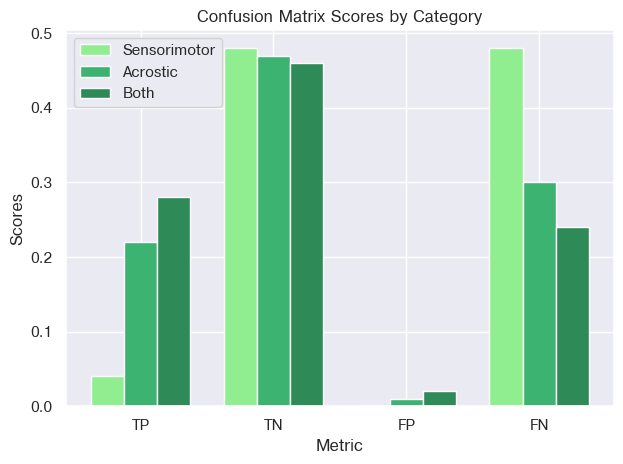

In [7]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'
# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# Data from the table
labels = ['TP', 'TN', 'FP', 'FN']
sensorimotor = [0.04, 0.48, 0.0, 0.48]
acrostic = [0.22, 0.47, 0.01, 0.30]
both = [0.28, 0.46, 0.02, 0.24]

# Indices and bar width
index = np.arange(len(labels))
bar_width = 0.25

# Plotting
fig, ax = plt.subplots()
bar1 = ax.bar(index - bar_width, sensorimotor, bar_width, label='Sensorimotor', color='lightgreen')
bar2 = ax.bar(index, acrostic, bar_width, label='Acrostic', color='mediumseagreen')
bar3 = ax.bar(index + bar_width, both, bar_width, label='Both', color='seagreen')

# Labels, title and legend
ax.set_xlabel('Metric')
ax.set_ylabel('Scores')
ax.set_title('Confusion Matrix Scores by Category')
ax.set_xticks(index)
ax.set_xticklabels(labels)
ax.legend()


# Display plot
plt.tight_layout()
plt.show()


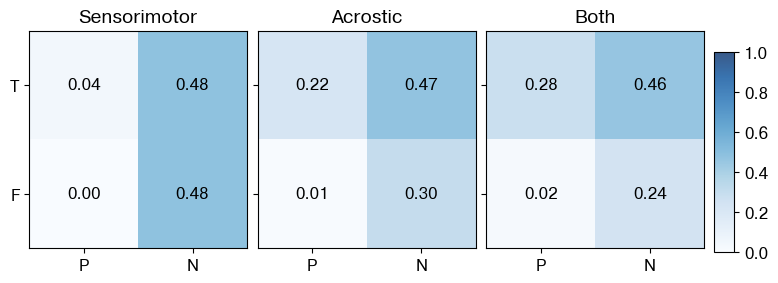

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

plt.rcParams['font.family'] = 'Helvetica'

# Updated data from the table
categories = ['Sensorimotor', 'Acrostic', 'Both']
data = np.array([
    [0.04, 0.48, 0.0, 0.48],  # Sensorimotor
    [0.22, 0.47, 0.01, 0.30],  # Acrostic
    [0.28, 0.46, 0.02, 0.24]   # Both
])

# Create a lighter colormap from the 'Blues' colormap
original_cmap = plt.cm.Blues
amount = 0.2
cmap_colors = original_cmap(np.arange(original_cmap.N))
lighter_colors = cmap_colors[:, :3] + (1.0 - cmap_colors[:, :3]) * amount
lighter_cmap = mcolors.LinearSegmentedColormap.from_list('lighter_' + original_cmap.name, lighter_colors)

# Create individual 2x2 matrices for each category
fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)  # Reduced figsize to better fit subplots

# Set font sizes
font_size = 12  # Larger font size for better readability
plt.rc('font', size=font_size)  # controls default text sizes
plt.rc('axes', titlesize=font_size+2)  # fontsize of the axes title
plt.rc('axes', labelsize=font_size+2)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size)  # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)  # fontsize of the tick labels

for idx, ax in enumerate(axes):
    # Reshape data[idx] into a 2x2 matrix
    matrix = data[idx].reshape(2, 2)
    im = ax.imshow(matrix, cmap=lighter_cmap, vmin=0, vmax=1)  # Ensure consistent color scaling
    
    # Setting axis titles and labels
    ax.set_title(categories[idx])
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['P', 'N'])#, rotation=0, ha='right')
    ax.set_yticklabels(['T', 'F'])

    # Annotate the cells with the numeric data
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, f'{matrix[i, j]:.2f}', ha="center", va="center", color="black")

# Adjust the position of the subplots to make room for the colorbar
fig.subplots_adjust(right=0.8, wspace=0.05)
# Place the colorbar
cbar_ax = fig.add_axes([0.81, 0.27, 0.02, 0.40])  # Adjusted the right and width parameters
fig.colorbar(im, cax=cbar_ax)

# Save and show the plot
plt.savefig('matrix_translation.png', dpi=300, bbox_inches='tight')
plt.show()

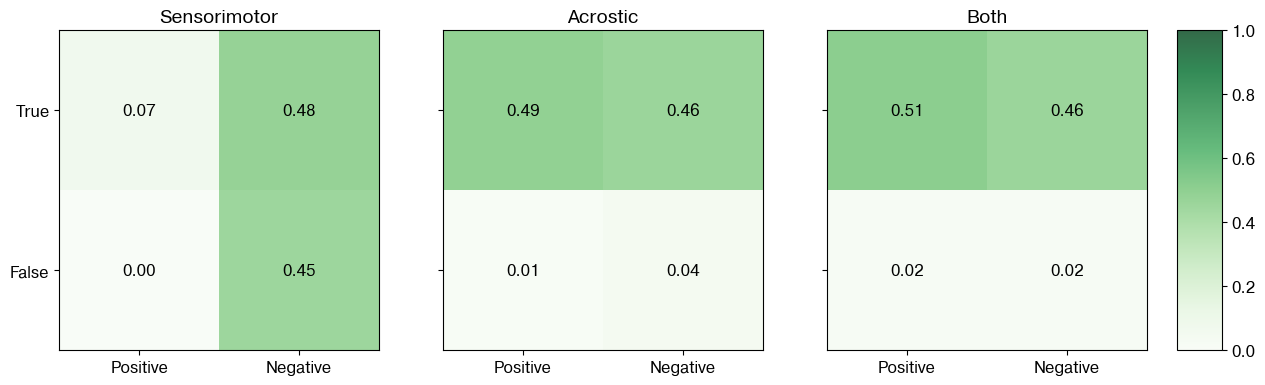

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'
# Updated data from the table
categories = ['Sensorimotor', 'Acrostic', 'Both']
data = np.array([
    [0.07, 0.48, 0.0, 0.45],  # Sensorimotor
    [0.49, 0.46, 0.01, 0.04],  # Acrostic
    [0.51, 0.46, 0.02, 0.02]   # Both
])
# Create a lighter colormap from the 'Oranges' colormap
original_cmap = plt.cm.Greens
amount = 0.2
cmap_colors = original_cmap(np.arange(original_cmap.N))
lighter_colors = cmap_colors[:, :3] + (1.0 - cmap_colors[:, :3]) * amount
lighter_cmap = mcolors.LinearSegmentedColormap.from_list('lighter_' + original_cmap.name, lighter_colors)

# Create individual 2x2 matrices for each category
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)  # Adjust figsize to better fit subplots

# Set font sizes
font_size = 12  # Larger font size for better readability
plt.rc('font', size=font_size)  # controls default text sizes
plt.rc('axes', titlesize=font_size+2)  # fontsize of the axes title
plt.rc('axes', labelsize=font_size+2)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size)  # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)  # fontsize of the tick labels

for idx, ax in enumerate(axes):
    # Reshape data[idx] into a 2x2 matrix
    matrix = data[idx].reshape(2, 2)
    im = ax.imshow(matrix, cmap=lighter_cmap, vmin=0, vmax=1)  # Ensure consistent color scaling
    
    # Setting axis titles and labels
    ax.set_title(categories[idx])
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['True', 'False'])

    # Annotate the cells with the numeric data
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, f'{matrix[i, j]:.2f}', ha="center", va="center", color="black")

# Adjust the position of the subplots to make room for the colorbar
fig.subplots_adjust(right=0.85)
# Place the colorbar
cbar_ax = fig.add_axes([0.87, 0.175, 0.03, 0.64])  # Adjusted the bottom and height parameters
fig.colorbar(im, cax=cbar_ax)

# Save and show the plot
plt.savefig('matrix.png', dpi=300, bbox_inches='tight')
plt.show()

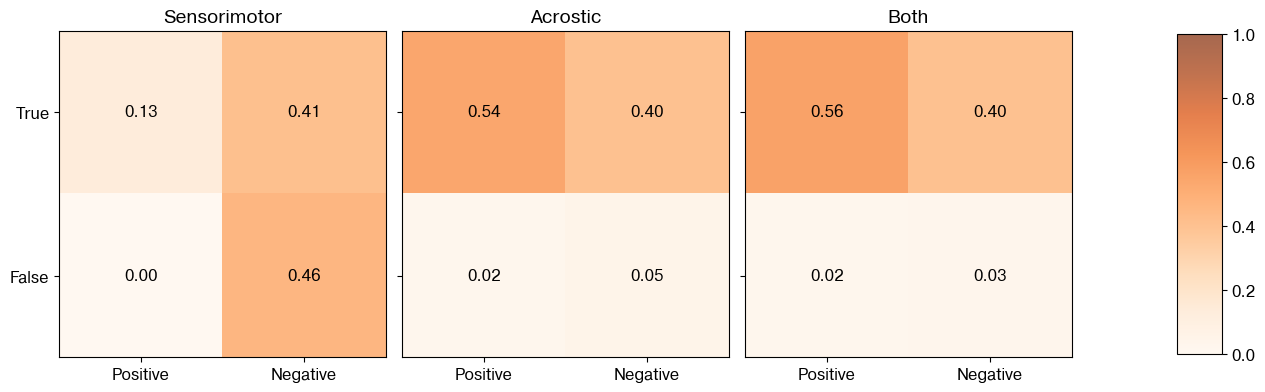

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

plt.rcParams['font.family'] = 'Helvetica'
# Data and categories
categories = ['Sensorimotor', 'Acrostic', 'Both']
data = np.array([
    [0.13, 0.41, 0.00, 0.46],  # Sensorimotor
    [0.54, 0.40, 0.02, 0.05],  # Acrostic
    [0.56, 0.40, 0.02, 0.03]   # Both
])

# Create a lighter colormap from the 'Oranges' colormap
original_cmap = plt.cm.Oranges
amount = 0.3
cmap_colors = original_cmap(np.arange(original_cmap.N))
lighter_colors = cmap_colors[:, :3] + (1.0 - cmap_colors[:, :3]) * amount
lighter_cmap = mcolors.LinearSegmentedColormap.from_list('lighter_' + original_cmap.name, lighter_colors)

# Create individual 2x2 matrices for each category
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)  # Adjust figsize to better fit subplots

# Set font sizes
font_size = 12  # Larger font size for better readability
plt.rc('font', size=font_size)  # controls default text sizes
plt.rc('axes', titlesize=font_size+2)  # fontsize of the axes title
plt.rc('axes', labelsize=font_size+2)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size)  # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)  # fontsize of the tick labels

for idx, ax in enumerate(axes):
    # Reshape data[idx] into a 2x2 matrix
    matrix = data[idx].reshape(2, 2)
    im = ax.imshow(matrix, cmap=lighter_cmap, vmin=0, vmax=1)  # Ensure consistent color scaling
    
    # Setting axis titles and labels
    ax.set_title(categories[idx])
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['True', 'False'])

    # Annotate the cells with the numeric data
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, f'{matrix[i, j]:.2f}', ha="center", va="center", color="black")

# Adjust the position of the subplots to make room for the colorbar
fig.subplots_adjust(right=0.8, wspace=0.05)
# Place the colorbar
cbar_ax = fig.add_axes([0.87, 0.175, 0.03, 0.64])  # Adjusted the bottom and height parameters
fig.colorbar(im, cax=cbar_ax)

# Save and show the plot
plt.savefig('llama2.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

plt.rcParams['font.family'] = 'Helvetica'
# Data and categories
categories = ['Red/Green', 'Stylometry',]
data = np.array([
    [0.08, 0.41, 0.00, 0.46],  # Sensorimotor
    [0.1, 0.40, 0.02, 0.05],  # Acrostic
    [0.56, 0.40, 0.02, 0.03]   # Both
])

# Create a lighter colormap from the 'Oranges' colormap
original_cmap = plt.cm.Oranges
amount = 0.3
cmap_colors = original_cmap(np.arange(original_cmap.N))
lighter_colors = cmap_colors[:, :3] + (1.0 - cmap_colors[:, :3]) * amount
lighter_cmap = mcolors.LinearSegmentedColormap.from_list('lighter_' + original_cmap.name, lighter_colors)

# Create individual 2x2 matrices for each category
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)  # Adjust figsize to better fit subplots

# Set font sizes
font_size = 12  # Larger font size for better readability
plt.rc('font', size=font_size)  # controls default text sizes
plt.rc('axes', titlesize=font_size+2)  # fontsize of the axes title
plt.rc('axes', labelsize=font_size+2)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size)  # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)  # fontsize of the tick labels

for idx, ax in enumerate(axes):
    # Reshape data[idx] into a 2x2 matrix
    matrix = data[idx].reshape(2, 2)
    im = ax.imshow(matrix, cmap=lighter_cmap, vmin=0, vmax=1)  # Ensure consistent color scaling
    
    # Setting axis titles and labels
    ax.set_title(categories[idx])
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['True', 'False'])

    # Annotate the cells with the numeric data
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, f'{matrix[i, j]:.2f}', ha="center", va="center", color="black")

# Adjust the position of the subplots to make room for the colorbar
fig.subplots_adjust(right=0.8, wspace=0.05)
# Place the colorbar
cbar_ax = fig.add_axes([0.87, 0.175, 0.03, 0.64])  # Adjusted the bottom and height parameters
fig.colorbar(im, cax=cbar_ax)

# Save and show the plot
plt.savefig('llama2.png', dpi=300, bbox_inches='tight')
plt.show()
